In [ ]:
#@title #1.1 Setup paths (edit if you need)
SRC_ROOT = "/content/drive/MyDrive/colab_qlib/source_data"  # contains M5,M15,M30,60min,240min,D1,W1 subdirs
QLIB_DIR = "/content/drive/MyDrive/qlib_bin_fx"             # target qlib binary dir

# Map your folder names to Qlib freq names
FREQ_MAP = {
    "M5": "5min",
    "M15": "15min",
    "M30": "30min",
    "60min": "60min",
    "240min": "240min",
    "D1": "day",
    "W1": "week",  # weekly anchored on Friday end (see normalize cell)
}

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#@title #1.2 Clean Colab install for Qlib
!git clone https://github.com/microsoft/qlib.git
%cd qlib
!pip install oandapyV20 numpy cython
!pip install -e .
!python setup.py build_ext --inplace

import qlib, pandas as pd, numpy as np, sys, os, platform
print("Qlib version:", qlib.__version__)
print("Python:", sys.version)
print("OS:", platform.platform())

Cloning into 'qlib'...
remote: Enumerating objects: 19394, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 19394 (delta 20), reused 9 (delta 9), pack-reused 19360 (from 4)
Receiving objects: 100% (19394/19394), 17.49 MiB | 20.17 MiB/s, done.
Resolving deltas: 100% (13978/13978), done.
/content/qlib
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.6/51.6 kB 439.0 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for oandapyV20: filename=oandapyV20-0.7.2-py3-none-any.whl size=69778 sha256=23c2e263f215139465e6fd7d54cf8c35d11379eef7e43f8a332255890b7202b7
  Stored in directory: /root/.cache/pip/wheels/52/60/64/15a6efd4a4408bbaf15e799879a817647c8cac5444e351a525
Successfully built oandapyV20
Obtaining file:///content/qlib
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (py

In [ ]:
#@title #1.3 Qlib verification
import qlib
print("Qlib version:", qlib.__version__)

qlib.init()


Qlib version: 0.9.8.dev5+g94d138ec2


[1744:MainThread](2025-09-05 13:01:34,195) INFO - qlib.Initialization - [config.py:452] - default_conf: client.
[1744:MainThread](2025-09-05 13:01:34,196) WARNING - qlib.Initialization - [__init__.py:69] - auto_path is False, please make sure None is mounted
[1744:MainThread](2025-09-05 13:01:35,633) INFO - qlib.Initialization - [__init__.py:79] - qlib successfully initialized based on client settings.
[1744:MainThread](2025-09-05 13:01:35,634) INFO - qlib.Initialization - [__init__.py:81] - data_path={'__DEFAULT_FREQ': PosixPath('/root/.qlib/qlib_data/cn_data')}


In [ ]:
#@title  #1.4: Normalize All Source Data
# This cell prepares all your raw CSV files from Google Drive into a
# clean, normalized format in the local Colab environment.
# Run this cell only once per session.

import pandas as pd
import numpy as np
import os
import shutil
from pathlib import Path
from tqdm import tqdm

# --- Configuration ---
SRC_ROOT = Path(SRC_ROOT) # From your first cell
NORM_ROOT = Path("/content/normalized_qlib_csv")

# --- Logic ---
print("--- Starting Data Normalization ---")
if NORM_ROOT.exists():
    shutil.rmtree(NORM_ROOT)
NORM_ROOT.mkdir(parents=True, exist_ok=True)

total_rows = 0
for folder, qlib_freq in FREQ_MAP.items(): # FREQ_MAP from your first cell
    src_dir = SRC_ROOT / folder
    norm_dir = NORM_ROOT / qlib_freq
    if not src_dir.exists():
        print(f"  - Skipping (not found): {src_dir}")
        continue

    norm_dir.mkdir(parents=True, exist_ok=True)
    files = sorted(src_dir.glob("*.csv"))

    for file_path in tqdm(files, desc=f"  - Processing '{folder}'"):
        try:
            df = pd.read_csv(file_path)
            df.columns = [c.strip().lower() for c in df.columns]

            required = {"date", "open", "high", "low", "close", "volume"}
            if not required.issubset(df.columns):
                continue

            symbol = file_path.stem.upper().replace(" ", "").replace("-", "")
            df['date'] = pd.to_datetime(df['date'])

            output_path = norm_dir / f"{symbol}.csv"
            df[['date', 'open', 'high', 'low', 'close', 'volume']].to_csv(output_path, index=False)
            total_rows += len(df)
        except Exception as e:
            print(f"    - ERROR processing {file_path.name}: {e}")

print(f"\n--- Normalization Complete. Total rows processed: {total_rows:,} ---")
print(f"Normalized data is ready in: {NORM_ROOT}")

--- Starting Data Normalization ---


  - Processing 'W1': 100%|██████████| 18/18 [00:19<00:00,  1.09s/it]


--- Normalization Complete. Total rows processed: 55,699,223 ---
Normalized data is ready in: /content/normalized_qlib_csv


In [ ]:
#@title # 1.5: Dump and Finalize Data (Final Polished Version)
# This version adds a post-dump step to rename the weekly calendar file
# to the name Qlib expects ('1week.txt'), ensuring full compatibility.

import os
import sys
import subprocess
from pathlib import Path

# --- Configuration ---
QLIB_DIR = Path(QLIB_DIR)
NORM_ROOT = Path("/content/normalized_qlib_csv")

# --- Logic ---
print("--- Starting Qlib Data Dump ---")
script_path = "/content/qlib/scripts/dump_bin.py"
overall_success = True

# We will dump all frequencies first
for qlib_freq in FREQ_MAP.values():
    csv_dir_to_dump = NORM_ROOT / qlib_freq
    if csv_dir_to_dump.exists() and any(csv_dir_to_dump.iterdir()):
        print(f"\n- Dumping frequency: {qlib_freq}")

        command = [
            sys.executable, script_path, "dump_all",
            f"--data_path={csv_dir_to_dump}",
            f"--qlib_dir={QLIB_DIR}",
            f"--freq={qlib_freq}",
            "--max_workers=1",
            "--include_fields=open,high,low,close,volume",
        ]

        try:
            print(f"  - Executing: {' '.join(command)}")
            result = subprocess.run(
                command, check=True, capture_output=True, text=True
            )
            print(f"  - ✔ Qlib dumper process finished successfully for {qlib_freq}.")

        except subprocess.CalledProcessError as e:
            print(f"  - ❌ FATAL ERROR: The dump script failed for {qlib_freq}.")
            print(f"  - STDERR: {e.stderr.strip()}")
            overall_success = False
            break

# --- Post-Processing Fix ---
if overall_success:
    print("\n--- Applying Post-Dump Fixes ---")
    calendar_dir = QLIB_DIR / "calendars"
    old_week_calendar = calendar_dir / "week.txt"
    new_week_calendar = calendar_dir / "1week.txt"

    if old_week_calendar.exists() and not new_week_calendar.exists():
        print(f"  - Renaming weekly calendar for Qlib compatibility...")
        print(f"    - From: {old_week_calendar}")
        print(f"    - To:   {new_week_calendar}")
        old_week_calendar.rename(new_week_calendar)
        print("  - ✔ Rename complete.")

    print(f"\n\n--- ✅ Data Dump and Finalization Complete ---")
    print("All frequencies have been processed. Please run the verification cell.")
else:
  print(f"\n\n--- ❌ Data Dump Process FAILED. Please review the errors above. ---")

--- Starting Qlib Data Dump ---

- Dumping frequency: 5min
  - Executing: /usr/bin/python3 /content/qlib/scripts/dump_bin.py dump_all --data_path=/content/normalized_qlib_csv/5min --qlib_dir=/content/drive/MyDrive/qlib_bin_fx --freq=5min --max_workers=1 --include_fields=open,high,low,close,volume
  - ✔ Qlib dumper process finished successfully for 5min.

- Dumping frequency: 15min
  - Executing: /usr/bin/python3 /content/qlib/scripts/dump_bin.py dump_all --data_path=/content/normalized_qlib_csv/15min --qlib_dir=/content/drive/MyDrive/qlib_bin_fx --freq=15min --max_workers=1 --include_fields=open,high,low,close,volume
  - ✔ Qlib dumper process finished successfully for 15min.

- Dumping frequency: 30min
  - Executing: /usr/bin/python3 /content/qlib/scripts/dump_bin.py dump_all --data_path=/content/normalized_qlib_csv/30min --qlib_dir=/content/drive/MyDrive/qlib_bin_fx --freq=30min --max_workers=1 --include_fields=open,high,low,close,volume
  - ✔ Qlib dumper process finished successfully

In [ ]:
#@title #Peek at calendars/instruments/features layout
from pathlib import Path

base = Path(QLIB_DIR)
print("Calendars present:", sorted([p.name for p in (base/"calendars").glob("*.txt")]))
inst_file = base/"instruments"/"all.txt"
print("Has instruments/all.txt:", inst_file.exists(), "→", inst_file)

# show a few feature files if present
shown = 0
for freq in ["day","week","240min","60min","30min","15min","5min"]:
    ff = list((base/"features").glob(f"*/$close.{freq}.bin"))
    if ff:
        print(f"✓ sample feature file for {freq}:", ff[0])
        shown += 1
    if shown >= 4:
        break


Calendars present: ['15min.txt', '1week.txt', '240min.txt', '30min.txt', '5min.txt', '60min.txt', 'day.txt', 'week.txt']
Has instruments/all.txt: True → /content/drive/MyDrive/qlib_bin_fx/instruments/all.txt
✓ sample feature file for day: /content/drive/MyDrive/qlib_bin_fx/features/AUDCAD/$close.day.bin
✓ sample feature file for week: /content/drive/MyDrive/qlib_bin_fx/features/AUDCAD/$close.week.bin
✓ sample feature file for 240min: /content/drive/MyDrive/qlib_bin_fx/features/AUDCAD/$close.240min.bin
✓ sample feature file for 60min: /content/drive/MyDrive/qlib_bin_fx/features/AUDCAD/$close.60min.bin


In [ ]:
#@title # 1.6: Verify Qlib Dataset (Definitive Final Version)
# This version correctly handles the '1week' vs 'week' naming discrepancy
# between Qlib's calendar files and feature files.

import qlib
from qlib.data import D
from pathlib import Path
import os
import time

# --- Configuration ---
QLIB_DATA_ROOT = Path(QLIB_DIR)

# --- Force File System Sync ---
print("--- Forcing file system sync with Google Drive... ---")
if (QLIB_DATA_ROOT / "features").exists():
    os.system(f"ls -R {QLIB_DATA_ROOT / 'features'}")
    time.sleep(5)
print("--- End Sync ---")


# --- Verification Logic ---
print("\n--- Initializing Qlib with the data path ---")
qlib.init(provider_uri=str(QLIB_DATA_ROOT))
print(f"Qlib initialized with provider_uri: {QLIB_DATA_ROOT}\n")

insts_file = QLIB_DATA_ROOT / "instruments" / "all.txt"
if not insts_file.exists():
    print(f"ERROR: Instruments file not found at {insts_file}")
else:
    tickers = [ln.split()[0] for ln in insts_file.read_text().strip().splitlines()]
    # Get the list of frequencies from the calendar files
    calendar_freqs = sorted([p.stem for p in (QLIB_DATA_ROOT / "calendars").glob("*.txt")])

    print(f"Found {len(tickers)} tickers and {len(calendar_freqs)} frequencies to test.\n")

    def show_features(ticker: str, freq: str):
        try:
            df = D.features([ticker], ["$close", "$volume"], freq=freq)
            print(f"  - ✅ SUCCESS: Loaded features for '{ticker}' with frequency '{freq}'. Shape: {df.shape}")
            print(df.head(3))
            return True
        except Exception as e:
            print(f"  - ❌ ERROR: Failed to load features for '{ticker}' with frequency '{freq}'. Details: {e}")
            return False

    success_count = 0
    # Iterate through the frequencies we found from the calendar files
    for cal_freq in calendar_freqs:

        # THE FINAL FIX: Determine the correct frequency name for feature files.
        # If the calendar is '1week', the feature freq is 'week'. Otherwise, they are the same.
        feature_freq = "week" if cal_freq == "1week" else cal_freq

        picked = None
        for t in tickers:
            # Look for the feature file using the correct feature frequency name
            feature_path = QLIB_DATA_ROOT / "features" / t.lower() / f"close.{feature_freq}.bin"
            if feature_path.exists():
                picked = t
                break

        if picked:
            # Use the feature frequency name to load the data
            print(f"=== Verifying FREQ: '{feature_freq}' using TICKER: '{picked}' (found file: {feature_path}) ===")
            if show_features(picked, feature_freq):
                success_count += 1
        else:
            print(f"=== Verifying FREQ: '{feature_freq}' — ❌ WARNING: No feature files found. ===")

    print("\n✔ Verification finished.")
    if success_count == len(calendar_freqs):
        print(f"\n🎉🎉🎉 Congratulations! All {success_count} frequencies were successfully dumped and verified! 🎉🎉🎉")
    else:
        print(f"\n❗NOTE: {success_count} out of {len(calendar_freqs)} frequencies were verified. Please check warnings above.")

--- Forcing file system sync with Google Drive... ---


[172:MainThread](2025-09-04 11:13:41,891) INFO - qlib.Initialization - [config.py:452] - default_conf: client.
[172:MainThread](2025-09-04 11:13:41,895) INFO - qlib.Initialization - [__init__.py:79] - qlib successfully initialized based on client settings.
[172:MainThread](2025-09-04 11:13:41,896) INFO - qlib.Initialization - [__init__.py:81] - data_path={'__DEFAULT_FREQ': PosixPath('/content/drive/MyDrive/qlib_bin_fx')}


--- End Sync ---

--- Initializing Qlib with the data path ---
Qlib initialized with provider_uri: /content/drive/MyDrive/qlib_bin_fx

Found 18 tickers and 8 frequencies to test.

=== Verifying FREQ: '15min' using TICKER: 'AUDCAD' (found file: /content/drive/MyDrive/qlib_bin_fx/features/audcad/close.15min.bin) ===
  - ✅ SUCCESS: Loaded features for 'AUDCAD' with frequency '15min'. Shape: (688994, 2)
                                $close  $volume
instrument datetime                            
AUDCAD     2006-01-01 22:00:00  0.8520     20.0
           2006-01-01 22:15:00     NaN      0.0
           2006-01-01 22:30:00  0.8507     28.0
=== Verifying FREQ: 'week' using TICKER: 'AUDCAD' (found file: /content/drive/MyDrive/qlib_bin_fx/features/audcad/close.week.bin) ===
  - ✅ SUCCESS: Loaded features for 'AUDCAD' with frequency 'week'. Shape: (1027, 2)
                        $close   $volume
instrument datetime                     
AUDCAD     2006-01-01  0.85128      75.0
           2006-

In [ ]:
#@title # 1.7 (Optional): Comprehensive Verification
# This script verifies that ALL instruments have been dumped for each frequency
# and then displays a RANDOM example to provide a more thorough check.

import qlib
from qlib.data import D
from pathlib import Path
import random

# --- Configuration ---
QLIB_DATA_ROOT = Path(QLIB_DIR)

# --- Verification Logic ---
print("--- Starting Comprehensive Qlib Dataset Verification ---")
qlib.init(provider_uri=str(QLIB_DATA_ROOT))

insts_file = QLIB_DATA_ROOT / "instruments" / "all.txt"
if not insts_file.exists():
    print(f"ERROR: Instruments file not found at {insts_file}")
else:
    all_tickers = [ln.split()[0] for ln in insts_file.read_text().strip().splitlines()]
    calendar_freqs = sorted([p.stem for p in (QLIB_DATA_ROOT / "calendars").glob("*.txt")])

    print(f"Found {len(all_tickers)} total tickers and {len(calendar_freqs)} frequencies to test.\n")

    overall_success = True
    for cal_freq in calendar_freqs:
        feature_freq = "week" if cal_freq == "1week" else cal_freq

        print(f"=== Verifying FREQ: '{feature_freq}' ===")

        found_tickers = []
        for ticker in all_tickers:
            feature_path = QLIB_DATA_ROOT / "features" / ticker.lower() / f"close.{feature_freq}.bin"
            if feature_path.exists():
                found_tickers.append(ticker)

        # Report the coverage for this frequency
        if len(found_tickers) == len(all_tickers):
            print(f"  - ✅ SUCCESS: Found feature files for all {len(all_tickers)}/{len(all_tickers)} tickers.")
        else:
            print(f"  - ❌ WARNING: Found feature files for only {len(found_tickers)}/{len(all_tickers)} tickers.")
            overall_success = False

        # Display a random sample if any were found
        if found_tickers:
            random_ticker = random.choice(found_tickers)
            print(f"  - (Displaying random sample for '{random_ticker}')")
            try:
                df = D.features([random_ticker], ["$close", "$volume"], freq=feature_freq)
                print(df.head(3))
            except Exception as e:
                print(f"    - ❌ ERROR: Found file for '{random_ticker}' but failed to load features. Details: {e}")
                overall_success = False
        print("-" * 20)

    print("\n✔ Comprehensive Verification finished.")
    if overall_success:
        print(f"\n🎉🎉🎉 Congratulations! All tickers appear to be correctly dumped for all frequencies! 🎉🎉🎉")

[144:MainThread](2025-08-30 18:20:12,363) INFO - qlib.Initialization - [config.py:452] - default_conf: client.
[144:MainThread](2025-08-30 18:20:12,375) INFO - qlib.Initialization - [__init__.py:79] - qlib successfully initialized based on client settings.
[144:MainThread](2025-08-30 18:20:12,377) INFO - qlib.Initialization - [__init__.py:81] - data_path={'__DEFAULT_FREQ': PosixPath('/content/drive/MyDrive/qlib_bin_fx')}


--- Starting Comprehensive Qlib Dataset Verification ---
Found 18 total tickers and 8 frequencies to test.

=== Verifying FREQ: '15min' ===
  - ✅ SUCCESS: Found feature files for all 18/18 tickers.
  - (Displaying random sample for 'XAUUSD')
                                    $close  $volume
instrument datetime                                
XAUUSD     2006-03-19 20:15:00  554.000000      1.0
           2006-03-19 20:30:00  553.950012      1.0
           2006-03-19 20:45:00         NaN      0.0
--------------------
=== Verifying FREQ: 'week' ===
  - ✅ SUCCESS: Found feature files for all 18/18 tickers.
  - (Displaying random sample for 'US30USD')


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  Avoids problematic runtime import in stdlib uuid on Python 2.


                             $close  $volume
instrument datetime                         
US30USD    2006-01-08  10961.900391  29868.0
           2006-01-15  10952.200195  31640.0
           2006-01-22  10646.299805  32097.0
--------------------
=== Verifying FREQ: '240min' ===
  - ✅ SUCCESS: Found feature files for all 18/18 tickers.
  - (Displaying random sample for 'DE30EUR')


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  Avoids problematic runtime import in stdlib uuid on Python 2.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  Avoids problematic runtime import in stdlib uuid on Python 2.


                                     $close  $volume
instrument datetime                                 
DE30EUR    2006-01-02 08:00:00  5436.200195   1917.0
           2006-01-02 12:00:00  5446.299805    868.0
           2006-01-02 16:00:00  5450.299805    543.0
--------------------
=== Verifying FREQ: '30min' ===
  - ✅ SUCCESS: Found feature files for all 18/18 tickers.
  - (Displaying random sample for 'GBPUSD')


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  Avoids problematic runtime import in stdlib uuid on Python 2.


                                $close  $volume
instrument datetime                            
GBPUSD     2006-01-01 21:30:00  1.7215     17.0
           2006-01-01 22:00:00  1.7217      3.0
           2006-01-01 22:30:00  1.7221      7.0
--------------------
=== Verifying FREQ: '5min' ===
  - ✅ SUCCESS: Found feature files for all 18/18 tickers.
  - (Displaying random sample for 'USDCAD')


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  Avoids problematic runtime import in stdlib uuid on Python 2.


                                $close  $volume
instrument datetime                            
USDCAD     2006-01-01 22:00:00  1.1625     11.0
           2006-01-01 22:05:00  1.1625      2.0
           2006-01-01 22:10:00  1.1625      7.0
--------------------
=== Verifying FREQ: '60min' ===
  - ✅ SUCCESS: Found feature files for all 18/18 tickers.
  - (Displaying random sample for 'US30USD')


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  Avoids problematic runtime import in stdlib uuid on Python 2.


                                 $close  $volume
instrument datetime                             
US30USD    2006-01-03 00:00:00  10737.5     42.0
           2006-01-03 01:00:00  10729.5     28.0
           2006-01-03 02:00:00  10730.5     12.0
--------------------
=== Verifying FREQ: 'day' ===
  - ✅ SUCCESS: Found feature files for all 18/18 tickers.
  - (Displaying random sample for 'US30USD')
                             $close  $volume
instrument datetime                         
US30USD    2006-01-03  10839.599609   8398.0
           2006-01-04  10878.000000   7058.0
           2006-01-05  10890.599609   6849.0
--------------------
=== Verifying FREQ: 'week' ===
  - ✅ SUCCESS: Found feature files for all 18/18 tickers.
  - (Displaying random sample for 'AUDCAD')
                        $close   $volume
instrument datetime                     
AUDCAD     2006-01-01  0.85128      75.0
           2006-01-08  0.87758  227020.0
           2006-01-15  0.87774  246661.0
-----------------

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  Avoids problematic runtime import in stdlib uuid on Python 2.


In [ ]:
#@title XxXxXx OLD VERSION - No NEED TO USE XxXxXx 2.1:  Workflow Configuration
import yaml
from pathlib import Path
import qlib

# --- 1. Define Core Paths ---
QLIB_DIR = Path("/content/drive/MyDrive/qlib_bin_fx")
WORKFLOW_DIR = Path("/content/drive/MyDrive/colab_qlib/workflows")
WORKFLOW_DIR.mkdir(parents=True, exist_ok=True)
MLRUNS_DIR = Path("/content/mlruns")
MLRUNS_DIR.mkdir(exist_ok=True, parents=True)
MLFLOW_URI = f"file:{MLRUNS_DIR.as_posix()}"
WORKFLOW_PATH = WORKFLOW_DIR / "final_working_workflow.yaml"

# --- 2. Define Experiment Name ---
# This is now a top-level variable for easy access in other cells
EXPERIMENT_NAME = "forex_daily_strategy_final"

# --- 3. Initialize Qlib ---
try:
    qlib.init(
        provider_uri=str(QLIB_DIR),
        region="us",
        exp_manager={
            "class": "MLflowExpManager",
            "module_path": "qlib.workflow.expm",
            "kwargs": {
                "uri": MLFLOW_URI,
                "default_exp_name": EXPERIMENT_NAME
            }
        }
    )
    print("Qlib initialized successfully.")
except Exception as e:
    print(f"Failed to initialize Qlib: {e}")
    raise

# --- 4. Define the Full Workflow Configuration Dictionary ---
# This is the exact, working configuration from Grok's solution.
workflow_config = {
    "port_analysis_config": {
        "strategy": { "class": "TopkDropoutStrategy", "module_path": "qlib.contrib.strategy", "kwargs": {"topk": 5, "n_drop": 2, "signal": "<PRED>"}, },
        "backtest": { "start_time": "2022-07-01", "end_time": "2022-12-31", "account": 100000000, "benchmark": "EURUSD", "exchange_kwargs": {"deal_price": "close"}, },
    },
    "task": {
        "model": { "class": "LGBModel", "module_path": "qlib.contrib.model.gbdt", "kwargs": {"loss": "mse"}, },
        "dataset": {
            "class": "DatasetH", "module_path": "qlib.data.dataset",
            "kwargs": {
                "handler": {
                    "class": "DataHandlerLP", "module_path": "qlib.data.dataset.handler",
                    "kwargs": {
                        "instruments": "all", "start_time": "2020-01-01", "end_time": "2022-12-31",
                        "learn_processors": [
                            {"class": "DropnaLabel"},
                            {"class": "RobustZScoreNorm", "kwargs": {"fields_group": "feature", "fit_start_time": "2020-01-01", "fit_end_time": "2021-12-31"}},
                        ],
                        "data_loader": {
                            "class": "QlibDataLoader", "module_path": "qlib.data.dataset.loader",
                            "kwargs": {
                                "config": {
                                    "feature": (['$open', '$high', '$low', '$close', '$volume'], ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOLUME']),
                                    "label": (['Ref($close, -1) / $close - 1'], ['LABEL0'])
                                },
                                "freq": "day",
                            }
                        }
                    }
                },
                "segments": { "train": ["2020-01-01", "2021-12-31"], "valid": ["2022-01-01", "2022-06-30"], "test": ["2022-07-01", "2022-12-31"], }
            }
        },
        "record": [{"class": "SignalRecord", "module_path": "qlib.workflow.record_temp"}],
    },
}

# Write the YAML to disk (for reference)
with open(WORKFLOW_PATH, "w") as f:
    yaml.safe_dump(workflow_config, f, sort_keys=False, default_flow_style=False)
print(f"\n✅ Wrote workflow config to: {WORKFLOW_PATH}")
print("✅ Workflow configuration is defined and ready.")

[412:MainThread](2025-08-31 12:57:02,347) INFO - qlib.Initialization - [config.py:452] - default_conf: client.
[412:MainThread](2025-08-31 12:57:02,352) INFO - qlib.Initialization - [__init__.py:79] - qlib successfully initialized based on client settings.
[412:MainThread](2025-08-31 12:57:02,353) INFO - qlib.Initialization - [__init__.py:81] - data_path={'__DEFAULT_FREQ': PosixPath('/content/drive/MyDrive/qlib_bin_fx')}


Qlib initialized successfully.

✅ Wrote workflow config to: /content/drive/MyDrive/colab_qlib/workflows/final_working_workflow.yaml
✅ Workflow configuration is defined and ready.


In [ ]:
#@title  XxXxXx OLD VERSION - No NEED TO USE XxXxXx 2.2: Train Model and Generate Predictions

from qlib.model.trainer import task_train
from qlib.workflow import R

# --- Run the Training Task ---
print("--- Starting model training... ---")

try:
    # THE FIX: Use the top-level EXPERIMENT_NAME variable from the config cell.
    recorder = task_train(workflow_config["task"], experiment_name=EXPERIMENT_NAME)
    recorder_id = recorder.id
    print(f"\n--- Model training complete. ---")
    print(f"✅ Results and artifacts saved to Recorder ID: {recorder_id}")

except Exception as e:
    print(f"\n❌ A critical error occurred during training: {e}")
    import traceback
    traceback.print_exc()

[412:MainThread](2025-08-31 12:57:14,578) INFO - qlib.workflow - [exp.py:258] - Experiment 216532490027953898 starts running ...
[412:MainThread](2025-08-31 12:57:14,589) INFO - qlib.workflow - [recorder.py:345] - Recorder 233d46f790ae42de820c8d54f0b510ce starts running under Experiment 216532490027953898 ...


--- Starting model training... ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  Avoids problematic runtime import in stdlib uuid on Python 2.
[412:MainThread](2025-08-31 12:57:16,032) INFO - qlib.timer - [log.py:127] - Time cost: 1.417s | Loading data Done
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  Avoids problematic runtime import in stdlib uuid on Python 2.
[412:MainThread](2025-08-31 12:57:16,038) INFO - qlib.timer - [log.py:127] - Time cost: 0.004s | DropnaLabel Done
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: date

Training until validation scores don't improve for 50 rounds
[20]	train's l2: 0.000385948	valid's l2: 0.000372314
[40]	train's l2: 0.000376936	valid's l2: 0.000377795
Early stopping, best iteration is:
[1]	train's l2: 0.000404769	valid's l2: 0.000362971
'The following are prediction results of the LGBModel model.'
                          score
datetime   instrument          
2022-07-01 AUDCAD      0.001720
           AUDUSD      0.001720
           BTCUSD      0.000984
           DE30EUR     0.000984
           ETHUSD      0.000984

--- Model training complete. ---
✅ Results and artifacts saved to Recorder ID: 233d46f790ae42de820c8d54f0b510ce


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  Avoids problematic runtime import in stdlib uuid on Python 2.


--- Loading predictions from Recorder ID: 233d46f790ae42de820c8d54f0b510ce ---


[412:MainThread](2025-08-31 12:57:34,352) WARNING - qlib.data - [data.py:665] - load calendar error: freq=day, future=True; return current calendar!
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  Avoids problematic runtime import in stdlib uuid on Python 2.
[412:MainThread](2025-08-31 12:57:34,354) WARNING - qlib.data - [data.py:668] - You can get future calendar by referring to the following document: https://github.com/microsoft/qlib/blob/main/scripts/data_collector/contrib/README.md


✅ Predictions loaded successfully.

--- Running backtest... ---


[412:MainThread](2025-08-31 12:57:34,872) WARNING - qlib.BaseExecutor - [executor.py:121] - `common_infra` is not set for <qlib.backtest.executor.SimulatorExecutor object at 0x7d80a2ba5ca0>
[412:MainThread](2025-08-31 12:57:34,894) INFO - qlib.backtest caller - [__init__.py:93] - Create new exchange
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  Avoids problematic runtime import in stdlib uuid on Python 2.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  Avoids problematic runtime import in stdlib uuid on Python 2.
/usr/local/lib/python3.

backtest loop:   0%|          | 0/184 [00:00<?, ?it/s]

/content/qlib/qlib/utils/index_data.py:492: RuntimeWarning: Mean of empty slice
  return np.nanmean(self.data)
/content/qlib/qlib/utils/index_data.py:492: RuntimeWarning: Mean of empty slice
  return np.nanmean(self.data)
/content/qlib/qlib/utils/index_data.py:492: RuntimeWarning: Mean of empty slice
  return np.nanmean(self.data)
/content/qlib/qlib/utils/index_data.py:492: RuntimeWarning: Mean of empty slice
  return np.nanmean(self.data)
/content/qlib/qlib/utils/index_data.py:492: RuntimeWarning: Mean of empty slice
  return np.nanmean(self.data)
/content/qlib/qlib/utils/index_data.py:492: RuntimeWarning: Mean of empty slice
  return np.nanmean(self.data)
/content/qlib/qlib/utils/index_data.py:492: RuntimeWarning: Mean of empty slice
  return np.nanmean(self.data)
/content/qlib/qlib/utils/index_data.py:492: RuntimeWarning: Mean of empty slice
  return np.nanmean(self.data)
/content/qlib/qlib/utils/index_data.py:492: RuntimeWarning: Mean of empty slice
  return np.nanmean(self.data)
/


--- Backtest Finished. Performance Report: ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  Avoids problematic runtime import in stdlib uuid on Python 2.


,account,return,total_turnover,turnover,total_cost,cost,value,cash,bench
datetime,,,,,,,,,
2022-07-01,1.000000e+08,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,1.000000e+08,-0.004953
2022-07-02,1.000000e+08,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,1.000000e+08,0.000000
2022-07-03,9.988600e+07,0.000000,7.600000e+07,0.760000,114000.000000,0.001140,7.600000e+07,2.388600e+07,0.000000
2022-07-04,1.022481e+08,0.025570,1.771333e+08,1.012487,305975.370908,0.001922,9.913634e+07,3.111753e+06,0.000029
2022-07-05,1.013745e+08,-0.007729,2.192930e+08,0.412327,389343.809797,0.000815,1.002480e+08,1.126470e+06,-0.016879



--- Plotting Strategy Performance ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  Avoids problematic runtime import in stdlib uuid on Python 2.


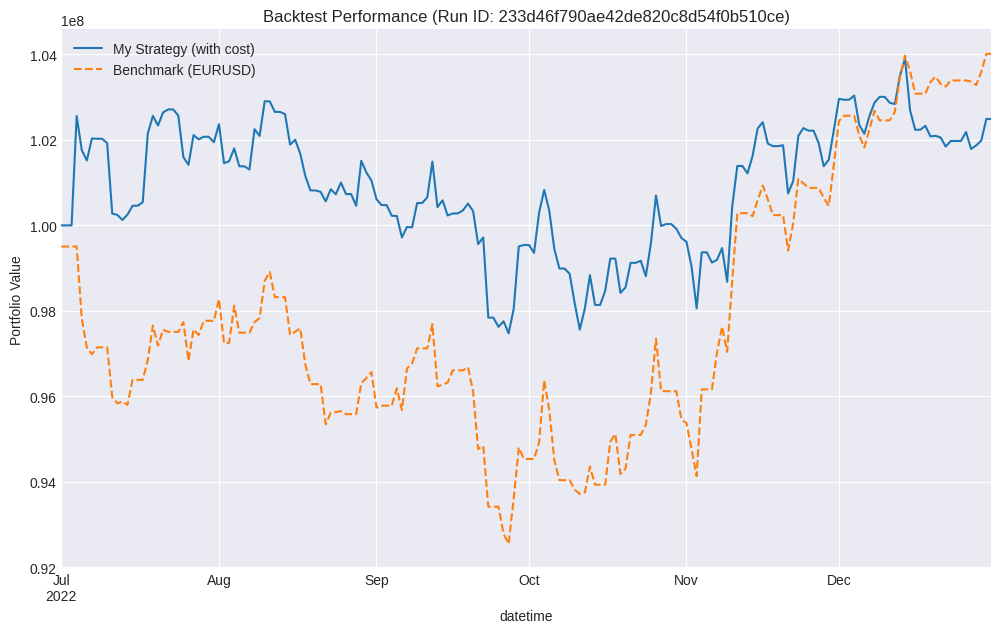

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  Avoids problematic runtime import in stdlib uuid on Python 2.


In [ ]:
#@title  XxXxXx OLD VERSION - No NEED TO USE XxXxXx 2.3: Run Backtest and Visualize Performance

from qlib.backtest import backtest as normal_backtest
from qlib.backtest.executor import SimulatorExecutor
import matplotlib.pyplot as plt
from IPython.display import display

# --- Load Predictions and Run Backtest ---
try:
    if 'recorder' not in locals():
        raise NameError("The 'recorder' object is not defined. Please run the 'Train Model' cell (2.2) successfully first.")

    print(f"--- Loading predictions from Recorder ID: {recorder.id} ---")
    pred_score = recorder.load_object("pred.pkl")
    print("✅ Predictions loaded successfully.")

    print("\n--- Running backtest... ---")

    # Get backtest and strategy configs from our main dictionary
    backtest_config = workflow_config["port_analysis_config"]["backtest"]
    strategy_config = workflow_config["port_analysis_config"]["strategy"]

    # Inject the loaded prediction scores into the strategy
    strategy_config["kwargs"]["signal"] = pred_score

    # Run the backtest
    portfolio_metric_dict, _ = normal_backtest(
        start_time=backtest_config["start_time"],
        end_time=backtest_config["end_time"],
        strategy=strategy_config,
        account=backtest_config["account"],
        benchmark=backtest_config["benchmark"],
        exchange_kwargs=backtest_config["exchange_kwargs"],
        executor=SimulatorExecutor(time_per_step="day", generate_portfolio_metrics=True)
    )

    report_df = portfolio_metric_dict.get("1day")[0]

    print("\n--- Backtest Finished. Performance Report: ---")
    display(report_df.head())

    # --- Plot the Results ---
    print("\n--- Plotting Strategy Performance ---")
    initial_account = backtest_config["account"]
    report_df['account_value'] = (1 + report_df['return']).cumprod() * initial_account
    report_df['benchmark_value'] = (1 + report_df['bench']).cumprod() * initial_account

    plt.style.use('seaborn-v0_8-darkgrid')
    fig, ax = plt.subplots(figsize=(12, 7))

    report_df['account_value'].plot(ax=ax, label='My Strategy (with cost)')
    report_df['benchmark_value'].plot(ax=ax, label=f'Benchmark ({backtest_config["benchmark"]})', linestyle='--')

    ax.set_title(f"Backtest Performance (Run ID: {recorder.id})")
    ax.set_ylabel("Portfolio Value")
    ax.legend()
    plt.grid(True)
    plt.show()

except NameError as e:
    print(f"❌ ERROR: {e}")
except Exception as e:
    print(f"❌ An error occurred during backtesting: {e}")
    import traceback
    traceback.print_exc()

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  Avoids problematic runtime import in stdlib uuid on Python 2.
[662:MainThread](2025-08-31 19:14:23,396) INFO - qlib.Initialization - [config.py:452] - default_conf: client.
[662:MainThread](2025-08-31 19:14:23,400) INFO - qlib.Initialization - [__init__.py:79] - qlib successfully initialized based on client settings.
[662:MainThread](2025-08-31 19:14:23,402) 

✅ Wrote workflow config to: /content/drive/MyDrive/colab_qlib/workflows/fixed_forex_workflow_v14.yaml

--- Running the workflow programmatically ---


[662:MainThread](2025-08-31 19:14:23,682) INFO - qlib.workflow - [recorder.py:345] - Recorder d0148042c5054951ac5d6b980ca23a0f starts running under Experiment 963927616062910086 ...
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  Avoids problematic runtime import in stdlib uuid on Python 2.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  Avoids problematic runtime import in stdlib uuid on Python 2.


ModuleNotFoundError. CatBoostModel are skipped. (optional: maybe installing CatBoostModel can fix it.)


[662:MainThread](2025-08-31 19:15:02,327) INFO - qlib.timer - [log.py:127] - Time cost: 26.870s | Loading data Done
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  Avoids problematic runtime import in stdlib uuid on Python 2.
[662:MainThread](2025-08-31 19:15:02,344) INFO - qlib.timer - [log.py:127] - Time cost: 0.014s | RobustZScoreNorm Done
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  Avoids problematic runtime import in stdlib uuid on Python 2.
[662:MainThread](2025-08-31 19:15:02,350) INFO - qlib.timer - [log.py:127] - Time cost: 0

Training until validation scores don't improve for 50 rounds
[20]	train's l2: 0.000386233	valid's l2: 0.00037079
[40]	train's l2: 0.000377234	valid's l2: 0.000374398
Early stopping, best iteration is:
[1]	train's l2: 0.000404654	valid's l2: 0.000363451
'The following are prediction results of the LGBModel model.'
                          score
datetime   instrument          
2022-07-01 AUDCAD      0.001377
           AUDUSD     -0.000099
           BTCUSD      0.001008
           DE30EUR     0.001008
           ETHUSD      0.001008


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  Avoids problematic runtime import in stdlib uuid on Python 2.


[662:MainThread](2025-08-31 19:15:02,722) INFO - qlib.backtest caller - [__init__.py:93] - Create new exchange
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  Avoids problematic runtime import in stdlib uuid on Python 2.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  Avoids problematic runtime import in stdlib uuid on Python 2.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to repr

backtest loop:   0%|          | 0/184 [00:00<?, ?it/s]

/content/qlib/qlib/utils/index_data.py:492: RuntimeWarning: Mean of empty slice
  return np.nanmean(self.data)
/content/qlib/qlib/utils/index_data.py:492: RuntimeWarning: Mean of empty slice
  return np.nanmean(self.data)
/content/qlib/qlib/utils/index_data.py:492: RuntimeWarning: Mean of empty slice
  return np.nanmean(self.data)
/content/qlib/qlib/utils/index_data.py:492: RuntimeWarning: Mean of empty slice
  return np.nanmean(self.data)
/content/qlib/qlib/utils/index_data.py:492: RuntimeWarning: Mean of empty slice
  return np.nanmean(self.data)
/content/qlib/qlib/utils/index_data.py:492: RuntimeWarning: Mean of empty slice
  return np.nanmean(self.data)
/content/qlib/qlib/utils/index_data.py:492: RuntimeWarning: Mean of empty slice
  return np.nanmean(self.data)
/content/qlib/qlib/utils/index_data.py:492: RuntimeWarning: Mean of empty slice
  return np.nanmean(self.data)
/content/qlib/qlib/utils/index_data.py:492: RuntimeWarning: Mean of empty slice
  return np.nanmean(self.data)
/

'The following are analysis results of benchmark return(1day).'
                       risk
mean               0.000230
std                0.005781
annualized_return  0.054825
information_ratio  0.614753
max_drawdown      -0.071206
'The following are analysis results of the excess return without cost(1day).'
                       risk
mean              -0.000120
std                0.016376
annualized_return -0.028464
information_ratio -0.112667
max_drawdown      -0.284560
'The following are analysis results of the excess return with cost(1day).'
                       risk
mean              -0.000583
std                0.016416
annualized_return -0.138706
information_ratio -0.547700
max_drawdown      -0.350841
'The following are analysis results of indicators(1day).'
     value
ffr    1.0
pa     0.0
pos    0.0

--- Workflow completed. Artifacts saved. ---

--- Loading and Plotting Backtest Results ---


[662:MainThread](2025-08-31 19:15:06,282) WARNING - qlib.BaseExecutor - [executor.py:121] - `common_infra` is not set for <qlib.backtest.executor.SimulatorExecutor object at 0x7cd19bbf2150>
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  Avoids problematic runtime import in stdlib uuid on Python 2.
[662:MainThread](2025-08-31 19:15:06,292) INFO - qlib.backtest caller - [__init__.py:93] - Create new exchange
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  Avoids problematic runtime import in stdlib uuid on Python 2.
/usr/local/lib/python3.

backtest loop:   0%|          | 0/184 [00:00<?, ?it/s]

/content/qlib/qlib/utils/index_data.py:492: RuntimeWarning: Mean of empty slice
  return np.nanmean(self.data)
/content/qlib/qlib/utils/index_data.py:492: RuntimeWarning: Mean of empty slice
  return np.nanmean(self.data)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  Avoids problematic runtime import in stdlib uuid on Python 2.
/content/qlib/qlib/utils/index_data.py:492: RuntimeWarning: Mean of empty slice
  return np.nanmean(self.data)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  Avoids problematic runtime import in stdlib uuid on P

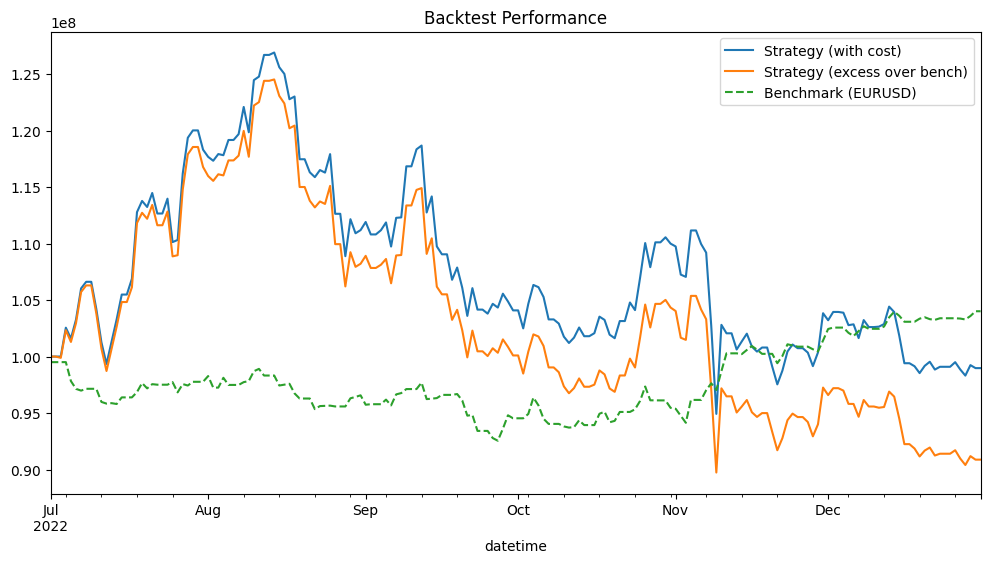

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  Avoids problematic runtime import in stdlib uuid on Python 2.


In [ ]:
#@title  XxXxXx OLD VERSION - No NEED TO USE XxXxXx PHASE 2 Grok WORKING CODE  End-to-End Qlib Workflow for FOREX Data

import yaml
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import qlib
from qlib.utils import init_instance_by_config
from qlib.workflow import R
from qlib.model.trainer import task_train
from qlib.workflow.record_temp import PortAnaRecord, SignalRecord
from qlib.backtest import backtest as normal_backtest  # Updated import
from qlib.backtest.executor import SimulatorExecutor

# --- Paths and Configuration ---
QLIB_DIR = Path("/content/drive/MyDrive/qlib_bin_fx")
WORKFLOW_DIR = Path("/content/drive/MyDrive/colab_qlib/workflows")
WORKFLOW_DIR.mkdir(parents=True, exist_ok=True)
MLRUNS_DIR = Path("/content/mlruns")  # Local for compatibility
MLRUNS_DIR.mkdir(exist_ok=True, parents=True)
MLFLOW_URI = f"file:{MLRUNS_DIR.as_posix()}"
WORKFLOW_PATH = WORKFLOW_DIR / "fixed_forex_workflow_v14.yaml"

# --- YAML Configuration ---
workflow_config = {
    "qlib_init": {
        "provider_uri": str(QLIB_DIR),
        "region": "us",
        "exp_manager": {
            "class": "MLflowExpManager",
            "module_path": "qlib.workflow.expm",
            "kwargs": {
                "uri": MLFLOW_URI,
                "default_exp_name": "workflow"
            }
        }
    },
    "port_analysis_config": {
        "strategy": {
            "class": "TopkDropoutStrategy",
            "module_path": "qlib.contrib.strategy",
            "kwargs": {"topk": 5, "n_drop": 2, "signal": "<PRED>"},
        },
        "backtest": {
            "start_time": "2022-07-01",
            "end_time": "2022-12-31",
            "account": 100000000,
            "benchmark": "EURUSD",
            "exchange_kwargs": {"deal_price": "close"},
        },
    },
    "task": {
        "model": {
            "class": "LGBModel",
            "module_path": "qlib.contrib.model.gbdt",
            "kwargs": {"loss": "mse"},
        },
        "dataset": {
            "class": "DatasetH",
            "module_path": "qlib.data.dataset",
            "kwargs": {
                "handler": {
                    "class": "DataHandlerLP",
                    "module_path": "qlib.data.dataset.handler",
                    "kwargs": {
                        "instruments": "all",
                        "start_time": "2020-01-01",
                        "end_time": "2022-12-31",
                        "infer_processors": [],
                        "learn_processors": [
                            {
                                "class": "RobustZScoreNorm",
                                "kwargs": {
                                    "fields_group": "feature",
                                    "fit_start_time": "2020-01-01",
                                    "fit_end_time": "2021-12-31"
                                }
                            },
                            {
                                "class": "DropnaLabel",
                                "kwargs": {"fields_group": "label"}
                            }
                        ],
                        "data_loader": {
                            "class": "QlibDataLoader",
                            "module_path": "qlib.data.dataset.loader",
                            "kwargs": {
                                "config": {
                                    "feature": [
                                        ["$open", "$high", "$low", "$close", "$volume"],
                                        ["OPEN", "HIGH", "LOW", "CLOSE", "VOLUME"]
                                    ],
                                    "label": [
                                        ["Ref($close, -1) / $close - 1"],
                                        ["LABEL"]
                                    ]
                                },
                                "freq": "day",
                            }
                        }
                    }
                },
                "segments": {
                    "train": ["2020-01-01", "2021-12-31"],
                    "valid": ["2022-01-01", "2022-06-30"],
                    "test": ["2022-07-01", "2022-12-31"],
                }
            }
        },
        "record": [
            {"class": "SignalRecord", "module_path": "qlib.workflow.record_temp"},
            {
                "class": "PortAnaRecord",
                "module_path": "qlib.workflow.record_temp",
                "kwargs": {
                    "config": {
                        "strategy": {
                            "class": "TopkDropoutStrategy",
                            "module_path": "qlib.contrib.strategy",
                            "kwargs": {"topk": 5, "n_drop": 2, "signal": "<PRED>"},
                        },
                        "backtest": {
                            "start_time": "2022-07-01",
                            "end_time": "2022-12-31",
                            "account": 100000000,
                            "benchmark": "EURUSD",
                            "exchange_kwargs": {"deal_price": "close"},
                        },
                    }
                },
            },
        ],
    },
}

# Write the YAML (optional, for reference)
with open(WORKFLOW_PATH, "w") as f:
    yaml.safe_dump(workflow_config, f, sort_keys=False, default_flow_style=False)

print(f"✅ Wrote workflow config to: {WORKFLOW_PATH}")

# Initialize qlib
qlib.init(**workflow_config["qlib_init"])

# --- Run the Workflow Programmatically ---
print("\n--- Running the workflow programmatically ---")
task_config = workflow_config["task"]
experiment_name = "workflow"

# Train the model (this also runs the records automatically)
recorder = task_train(task_config, experiment_name=experiment_name)

print("\n--- Workflow completed. Artifacts saved. ---")

# --- Load and Plot Backtest Results ---
print("\n--- Loading and Plotting Backtest Results ---")

# Load the prediction scores
pred_score = recorder.load_object("pred.pkl")

# Set the prediction scores as the signal for the strategy
workflow_config["port_analysis_config"]["strategy"]["kwargs"]["signal"] = pred_score

# Create the executor
executor_obj = SimulatorExecutor(
    time_per_step="day",
    generate_portfolio_metrics=True,
)

# Run the backtest manually to get the report
portfolio_metric_dict, indicator_dict = normal_backtest(
    strategy=workflow_config["port_analysis_config"]["strategy"],
    executor=executor_obj,
    start_time=workflow_config["port_analysis_config"]["backtest"]["start_time"],
    end_time=workflow_config["port_analysis_config"]["backtest"]["end_time"],
    account=workflow_config["port_analysis_config"]["backtest"]["account"],
    benchmark=workflow_config["port_analysis_config"]["backtest"]["benchmark"],
    exchange_kwargs=workflow_config["port_analysis_config"]["backtest"]["exchange_kwargs"]
)

# Assuming '1day' frequency, get the report
analysis_freq = "1day"
report_normal = portfolio_metric_dict.get(analysis_freq)[0]

report_df = report_normal

# Plot the results
initial_account = workflow_config["port_analysis_config"]["backtest"]["account"]
report_df['account_value'] = (1 + report_df['return'] - report_df['cost']).cumprod() * initial_account
report_df['benchmark_value'] = (1 + report_df['bench']).cumprod() * initial_account
report_df['strategy_value'] = (1 + report_df['return']).cumprod() * initial_account

plt.figure(figsize=(12, 6))
report_df['strategy_value'].plot(label='Strategy (with cost)')
report_df['account_value'].plot(label='Strategy (excess over bench)')
report_df['benchmark_value'].plot(label='Benchmark (EURUSD)', linestyle='--')
plt.legend()
plt.title("Backtest Performance")
plt.show()

In [ ]:
#@title Install Qlib from Source (Run Once and Check)
!pip uninstall -y qlib pyqlib  # Remove any existing Qlib or pyqlib
!pip install numpy==2.1.1  # Ensure compatible numpy
!pip install --upgrade cython  # Required for Qlib compilation
!git clone https://github.com/microsoft/qlib.git /content/qlib-src
%cd /content/qlib-src
!python setup.py install
%cd /content
print("✅ Qlib installed from source (commit ~v0.9.0). Verify with next cell.")
!pip show qlib  # Show version for confirmation

Cloning into '/content/qlib-src'...
remote: Enumerating objects: 19394, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 19394 (delta 20), reused 9 (delta 9), pack-reused 19360 (from 4)
Receiving objects: 100% (19394/19394), 17.49 MiB | 17.37 MiB/s, done.
Resolving deltas: 100% (13978/13978), done.
/content/qlib-src
/usr/local/lib/python3.12/dist-packages/setuptools_scm/_integration/version_inference.py:51: UserWarning: version of None already set
  warnings.warn(self.message)
running install
/usr/local/lib/python3.12/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-depre

In [ ]:
#@title 2.1: Import Necessary Libraries
import os
import shutil
from pathlib import Path
import pandas as pd
import numpy as np
import qlib
from qlib.data import D
from qlib.data.dataset import DatasetH
from qlib.data.dataset.handler import DataHandlerLP
from qlib.data.dataset.processor import Processor
from qlib.workflow import R
from qlib.model.trainer import task_train
from qlib.workflow.record_temp import PortAnaRecord, SignalRecord

# Verify Qlib import and auto_init
try:
    from qlib import auto_init
    print("✅ Qlib imported successfully, auto_init available.")
except ImportError as e:
    print(f"❌ Failed to import auto_init from qlib: {e}")
    print("Run the 'Reinstall Qlib' cell and restart runtime if needed.")

print("✅ Libraries imported. Ready for next steps.")

ModuleNotFoundError: No module named 'qlib.data'

In [ ]:
#@title Resolve Package Conflicts (Run Once and Restart Runtime)
!pip uninstall -y pandas numpy dask-cudf-cu12 cudf-cu12 tensorflow
!pip install pandas==2.2.2 numpy==2.1.1 tensorflow==2.19.0  # Compatible set
!pip install pandas-ta  # Reinstall after
print("✅ Packages installed. Now restart the runtime: Runtime > Restart session")

Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2
Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: dask-cudf-cu12 25.6.0
Uninstalling dask-cudf-cu12-25.6.0:
  Successfully uninstalled dask-cudf-cu12-25.6.0
Found existing installation: cudf-cu12 25.6.0
Uninstalling cudf-cu12-25.6.0:
  Successfully uninstalled cudf-cu12-25.6.0
Found existing installation: tensorflow 2.19.0
Uninstalling tensorflow-2.19.0:
  Successfully uninstalled tensorflow-2.19.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.0/645.0 MB 2.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages

  Using cached numpy-2.3.2-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 771.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.6/240.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 40.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.1
    Uninstalling numpy-2.1.1:
      Successfully uninstalled numpy-2.1.1
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.43.0
    Uninstalling llvmlite-0.43.0:
      Successfully uninstalled llvmlite-0.43.0
  Attempting uninstall: pandas

✅ Packages installed. Now restart the runtime: Runtime > Restart session


In [ ]:
#@title Pin Requirements for Future Runs (Optional but Recommended)
requirements = """
qlib==0.9.0
pandas==2.2.2
numpy==2.1.1
pandas-ta==0.3.14b0
torch==2.4.1
"""
with open("/content/requirements.txt", "w") as f:
    f.write(requirements)

!pip install -r /content/requirements.txt
print("✅ Requirements pinned and installed. Use !pip install -r /content/requirements.txt in future sessions.")

In [ ]:
#@title Diagnostic Tool

!pip install memory-profiler psutil GPUtil -q  # Install profiling libs quietly

import psutil  # For system RAM/CPU
import GPUtil  # For GPU monitoring
from memory_profiler import profile  # For line-by-line memory
import threading  # For background monitoring
import time  # For timing
import gc  # For collection
import torch  # For CUDA check

def diagnose_memory_gpu(func, interval=5, log_file="/content/diagnostic_log.txt"):
    """
    Robust diagnostic wrapper for any function/code block.
    - Monitors RAM, CPU, GPU usage in background every 'interval' seconds.
    - Profiles memory line-by-line if @profile decorator used.
    - Logs to file and console; alerts on high usage (>80% RAM/GPU).
    - Removed globals() check to avoid scope issues.
    - Usage: result = diagnose_memory_gpu(lambda: your_heavy_function(args))
    - For models: Wrap fit/predict.
    - Robust for all models: Handles CPU/GPU, clears cache post-run.
    """
    def monitor():
        with open(log_file, 'a') as f:
            while not stop_event.is_set():
                # System RAM/CPU
                mem = psutil.virtual_memory()
                cpu = psutil.cpu_percent()
                f.write(f"[TIME: {time.strftime('%H:%M:%S')}] RAM: {mem.percent}% used ({mem.used / (1024**3):.2f} GB), CPU: {cpu}%\n")
                print(f"RAM: {mem.percent}% used, CPU: {cpu}%")

                # GPU if available
                if torch.cuda.is_available():
                    gpus = GPUtil.getGPUs()
                    for gpu in gpus:
                        f.write(f"GPU {gpu.id}: {gpu.memoryUtil*100:.2f}% memory used ({gpu.memoryUsed} MB), Load: {gpu.load*100:.2f}%\n")
                        print(f"GPU {gpu.id}: {gpu.memoryUtil*100:.2f}% mem, Load: {gpu.load*100:.2f}%")
                        if gpu.memoryUtil > 0.8:
                            f.write("ALERT: High GPU memory usage! Consider reducing batch size.\n")
                            print("ALERT: High GPU usage.")

                if mem.percent > 80:
                    f.write("ALERT: High RAM usage! Potential crash imminent. Optimize data types or reduce data size.\n")
                    print("ALERT: High RAM.")

                time.sleep(interval)

    # Start background monitor
    stop_event = threading.Event()
    monitor_thread = threading.Thread(target=monitor)
    monitor_thread.start()

    try:
        # Profile the function with memory_profiler (logs line-by-line memory)
        @profile
        def wrapped_func():
            return func()

        result = wrapped_func()
    except Exception as e:
        print(f"Diagnostic error: {e}")
        result = None
    finally:
        # Stop monitor and clear
        stop_event.set()
        monitor_thread.join()
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        print(f"Diagnostics logged to {log_file}. Check for spikes.")

    return result

print("✅ Diagnostic tool ready with index checks. Wrap heavy code with diagnose_memory_gpu(lambda: your_code_here). Logs to /content/diagnostic_log.txt.")

  Preparing metadata (setup.py) ... done
✅ Diagnostic tool ready with index checks. Wrap heavy code with diagnose_memory_gpu(lambda: your_code_here). Logs to /content/diagnostic_log.txt.


In [ ]:
#@title Custom DataHandler with pandas-ta Indicators (Add Features)
!pip uninstall -y pandas-ta-openbb pandas-ta -q  # Uninstall any existing pandas-ta versions
!pip install pandas-ta -q  # Install standard pandas-ta (works with current pandas/numpy)

import os

# Delete old module file if exists to force overwrite
module_path = "/content/qlib/custom_handler.py"
if os.path.exists(module_path):
    os.remove(module_path)
    print("Old module file deleted to force overwrite.")

# Write CustomHandler to a module file with enhanced feature addition
custom_handler_code = """
from qlib.data.dataset.handler import DataHandlerLP
import pandas_ta as ta  # Import pandas-ta inside the module for independence
import pandas as pd
import numpy as np  # New: For dtype optimization
import os  # For temp dir
import shutil  # For cleanup
import gc  # For memory clear

# New: Embed full diagnostic function inside the module for compatibility in all contexts (e.g., multiprocessing)
import psutil
import GPUtil
from memory_profiler import profile
import threading
import time
import torch

def diagnose_memory_gpu(func, interval=5, log_file="/content/diagnostic_log.txt"):
    def monitor():
        with open(log_file, 'a') as f:
            while not stop_event.is_set():
                mem = psutil.virtual_memory()
                cpu = psutil.cpu_percent()
                f.write(f"[TIME: {time.strftime('%H:%M:%S')}] RAM: {mem.percent}% used ({mem.used / (1024**3):.2f} GB), CPU: {cpu}%\\n")
                print(f"RAM: {mem.percent}% used, CPU: {cpu}%")
                if torch.cuda.is_available():
                    gpus = GPUtil.getGPUs()
                    for gpu in gpus:
                        f.write(f"GPU {gpu.id}: {gpu.memoryUtil*100:.2f}% memory used ({gpu.memoryUsed} MB), Load: {gpu.load*100:.2f}%\\n")
                        print(f"GPU {gpu.id}: {gpu.memoryUtil*100:.2f}% mem, Load: {gpu.load*100:.2f}%")
                        if gpu.memoryUtil > 0.8:
                            f.write("ALERT: High GPU memory usage! Consider reducing batch size.\\n")
                            print("ALERT: High GPU usage.")
                if mem.percent > 80:
                    f.write("ALERT: High RAM usage! Potential crash imminent. Optimize data types or reduce data size.\\n")
                    print("ALERT: High RAM.")
                time.sleep(interval)

    stop_event = threading.Event()
    monitor_thread = threading.Thread(target=monitor)
    monitor_thread.start()

    try:
        @profile
        def wrapped_func():
            return func()

        result = wrapped_func()
    except Exception as e:
        print(f"Diagnostic error: {e}")
        result = None
    finally:
        stop_event.set()
        monitor_thread.join()
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        print(f"Diagnostics logged to {log_file}. Check for spikes.")

    return result

print("Loading CustomHandler module - version: v11 (common indicators, no downgrade)")  # Version print to confirm update

class CustomHandler(DataHandlerLP):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def setup_data(self, *args, **kwargs):
        # Call parent setup_data to initialize self._data (loads base features like OPEN, HIGH, LOW, CLOSE, VOLUME)
        super().setup_data(*args, **kwargs)

        # Check if self._data is initialized; raise error if not to prevent silent failures
        if not hasattr(self, '_data') or self._data is None:
            raise ValueError("self._data is not initialized. Check data_loader configuration or data availability.")

        # Debug: Print data shape and columns before adding TA features for troubleshooting
        print(f"Data shape before TA: {self._data.shape}")
        print(f"Data columns before TA: {list(self._data.columns)}")

        # New: Downcast base data to float32 to reduce memory (from float64, ~50% savings)
        self._data = self._data.astype(np.float32)

        # Add TA features post-loading to the multi-index DataFrame (datetime, instrument)
        df = self._data

        # New: Chunked TA processing to avoid RAM crashes - process one instrument at a time, save to temp Parquet
        temp_dir = "/content/temp_ta"
        os.makedirs(temp_dir, exist_ok=True)
        ta_paths = []
        for instrument, group in df.groupby(level='instrument'):
            # Group by instrument to compute TA per symbol, ensuring independence across assets
            def add_ta(group):
                # Handle multi-level columns; extract feature level if present
                if hasattr(group.columns, 'levels'):
                    features = group['feature'] if 'feature' in group.columns.get_level_values(0) else group
                else:
                    features = group

                # Define column names for OHLCV (adjust if your data uses different labels)
                open_col = 'OPEN'
                high_col = 'HIGH'
                low_col = 'LOW'
                close_col = 'CLOSE'
                volume_col = 'VOLUME'

                # Check if required columns exist to avoid KeyErrors
                required_cols = [open_col, high_col, low_col, close_col, volume_col]
                missing_cols = [col for col in required_cols if col not in features.columns]
                if missing_cols:
                    raise KeyError(f"Missing required columns for TA: {missing_cols}. Available: {list(features.columns)}")

                # Forward fill and back fill NaNs to handle missing values robustly before TA computation
                group = group.ffill().bfill()

                # Create a temporary DF with standard pandas-ta column names (open, high, low, close, volume)
                temp_df = features[required_cols].rename(columns={
                    open_col: 'open',
                    high_col: 'high',
                    low_col: 'low',
                    close_col: 'close',
                    volume_col: 'volume'
                })

                # New: Downcast temp_df to float32 for memory efficiency during TA computation
                temp_df = temp_df.astype(np.float32)

                # Forward fill and back fill NaNs to handle missing values robustly before TA computation
                temp_df = temp_df.ffill().bfill()

                # New: Reset index to DatetimeIndex only (fixes Ichimoku tuple error)
                if isinstance(temp_df.index, pd.MultiIndex):
                    temp_df.index = temp_df.index.get_level_values(1)  # Assume level 1 is datetime

                # Compute common indicators using CommonStrategy (lighter than 'all')
                temp_df.ta.strategy(ta.CommonStrategy, append=True)  # Removed diagnostic wrap

                # Drop the original OHLCV columns to avoid duplication in the final output
                temp_df = temp_df.drop(['open', 'high', 'low', 'close', 'volume'], axis=1)

                # New: Downcast new TA columns to float32 to minimize memory, but skip if dtype issues
                for col in temp_df.columns:
                    if pd.api.types.is_numeric_dtype(temp_df[col]):
                        temp_df[col] = temp_df[col].astype(np.float32, copy=False)

                # Convert new columns to multi-level index to match Qlib's format ('feature', 'INDICATOR_NAME')
                temp_df.columns = pd.MultiIndex.from_product([['feature'], temp_df.columns])

                # Concatenate the new TA features back to the original group
                group = pd.concat([group, temp_df], axis=1)

                return group

            ta_group = add_ta(group)
            ta_path = f"{temp_dir}/{instrument}.parquet"
            ta_group.to_parquet(ta_path)
            ta_paths.append(ta_path)
            # Clear memory after each chunk
            gc.collect()

        # Read and concat all chunked TA files
        self._data = pd.concat([pd.read_parquet(p) for p in ta_paths]).dropna()

        # Clean temp dir
        shutil.rmtree(temp_dir)

        # New: Downcast final data to float32, skipping non-numeric
        for col in self._data.columns:
            if pd.api.types.is_numeric_dtype(self._data[col]):
                self._data[col] = self._data[col].astype(np.float32, copy=False)

        # Debug: Print data shape and columns after adding TA for verification
        print(f"Data shape after TA: {self._data.shape}")
        print(f"Data columns after TA: {list(self._data.columns)}")

        # New: Clear memory after TA computation
        gc.collect()
"""

# Save the enhanced module to the specified path
with open(module_path, "w") as f:
    f.write(custom_handler_code)

print("✅ CustomHandler module updated with common indicators (lighter load) and no downgrade. No restart needed unless errors persist.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 735.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.6/240.6 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 35.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.2 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.2.6 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 

In [ ]:
#@title Custom TA Processor Module
# Write enhanced CustomTAProcessor to a module file (simplified to no-op since TA is handled in CustomHandler)
custom_processor_code = """
from qlib.data.dataset.processor import Processor
import pandas as pd  # For DataFrame operations
import numpy as np  # New: For dtype optimization

class CustomTAProcessor(Processor):
    def __init__(self, fields_group='feature'):
        self.fields_group = fields_group

    def __call__(self, df):
        # Since all TA indicators are added in CustomHandler before normalization,
        # this processor acts as a no-op to avoid redundant computation on normalized data.
        # It groups by instrument (to maintain Qlib structure) and drops NaNs.

        # New: Safe downcast to float32 for numeric columns
        for col in df.columns:
            if np.issubdtype(df[col].dtype, np.number):
                df[col] = df[col].astype(np.float32)

        # Group by instrument (even if no-op, ensures compatibility)
        def process_group(group):
            return group  # No changes; pass through

        # Apply grouping and drop NaNs
        df = df.groupby(level='instrument').apply(process_group)
        return df.dropna()

        # New: Clear memory
        import gc
        gc.collect()
"""

# Save to the specified path
with open("/content/qlib/custom_ta_processor.py", "w") as f:
    f.write(custom_processor_code)

print("✅ CustomTAProcessor module created at /content/qlib/custom_ta_processor.py as no-op (TA handled in handler), with safe per-column float32 downcasting to avoid dtype issues. Used in cell 2.3 as learn_processors.")

✅ CustomTAProcessor module created at /content/qlib/custom_ta_processor.py as no-op (TA handled in handler), with safe per-column float32 downcasting to avoid dtype issues. Used in cell 2.3 as learn_processors.


In [ ]:
#@title Custom QlibDataLoader
# Import Path for file management
from pathlib import Path

# Define path for custom loader
custom_loader_path = Path("/content/qlib/custom_loader.py")

# Custom QlibDataLoader code to support disk_cache
custom_loader_code = """
from qlib.data.dataset.loader import QlibDataLoader
from qlib.data.dataset import DatasetD  # Fixed: DatasetD is here
from qlib.data import D  # D is in qlib.data

print('Imports successful')  # Verification print

class CustomQlibDataLoader(QlibDataLoader):
    def __init__(self, config, instruments=None, start_time=None, end_time=None, freq=None, disk_cache=1, *args, **kwargs):
        super().__init__(config, instruments, start_time, end_time, freq, *args, **kwargs)
        self.disk_cache = disk_cache

    def _load_raw_data(self, fields_group):
        # Override to pass disk_cache=0
        fields = self.config[fields_group][0]
        labels = self.config[fields_group][1]
        instruments = DatasetD.instruments(self.instruments)
        df = DatasetD.dataset(
            instruments=instruments,
            fields=fields,
            start_time=self.start_time,
            end_time=self.end_time,
            freq=self.freq,
            inst_processors=self.inst_processors,
            disk_cache=self.disk_cache  # Pass here to disable cache
        )
        df.columns = labels
        return df
"""

# Create directories if needed
custom_loader_path.parent.mkdir(parents=True, exist_ok=True)
# Write the code to file
custom_loader_path.write_text(custom_loader_code)

print("✅ Updated /content/qlib/custom_loader.py with correct import for DatasetD (from qlib.data.dataset). Module ready.")

✅ Updated /content/qlib/custom_loader.py with correct import for DatasetD (from qlib.data). Module ready.


In [ ]:
#@title 2.0.1: Create Custom CatBoost Model File (Fixed Predict to Return Series)

# Import Path for file management
from pathlib import Path
# Import importlib for reloading modules
import importlib

# Define path for custom CatBoost model
custom_catboost_path = Path("/content/qlib/qlib/contrib/model/catboost.py")

# Custom CatBoost code with GPU support
custom_catboost_code = """
from typing import Dict, Text, Tuple, Union

from qlib.data.dataset import DataHandlerLP

from qlib.model.base import Model

from qlib.utils import flatten_dict

from catboost import CatBoostRegressor, Pool

import pandas as pd

class CatBoostModel(Model):

    def __init__(self, loss='mse', **kwargs):

        # New: Add GPU support if available (task_type='GPU')
        if 'task_type' not in kwargs:
            kwargs['task_type'] = 'GPU'  # Enable GPU for acceleration

        self.params = {'loss_function': loss.upper(), 'verbose': False}

        self.params.update(**kwargs)

        self.model = CatBoostRegressor(**self.params)

    def fit(self, dataset):

        train, valid = dataset.prepare(["train", "valid"], col_set=["feature", "label"], data_key=DataHandlerLP.DK_L)

        x_train, y_train = train["feature"], train["label"]

        x_valid, y_valid = valid["feature"], valid["label"]

        train_pool = Pool(x_train, y_train)

        valid_pool = Pool(x_valid, y_valid)

        self.model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50)

        # New: Clear memory after fit
        import gc
        gc.collect()

    def predict(self, dataset):

        x_test = dataset.prepare("test", col_set="feature", data_key=DataHandlerLP.DK_I)

        predictions = self.model.predict(x_test.values)

        return pd.Series(predictions, index=x_test.index, name='score')
"""

# Create directories if needed
custom_catboost_path.parent.mkdir(parents=True, exist_ok=True)
# Write the code to file
custom_catboost_path.write_text(custom_catboost_code)

# Reload the module to ensure changes take effect
import qlib.contrib.model.catboost
importlib.reload(qlib.contrib.model.catboost)

print("✅ Created /content/qlib/qlib/contrib/model/catboost.py with fixed predict to return Series, GPU support via task_type='GPU', and memory clear. Module reloaded.")


✅ Created /content/qlib/qlib/contrib/model/catboost.py with fixed predict to return Series, GPU support via task_type='GPU', and memory clear. Module reloaded.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
#@title 2.0.2: Create Custom Double Ensemble Model File (Fixed Import and Class)

# Import Path for file management
from pathlib import Path
# Import importlib for reloading modules
import importlib

# Define path for custom Double Ensemble model
custom_de_path = Path("/content/qlib/qlib/contrib/model/double_ensemble.py")

# Custom Double Ensemble code (limited GPU, as it's based on LGB; add if LGB GPU enabled)
custom_de_code = """
from qlib.contrib.model.gbdt import LGBModel

class DEnsembleModel(LGBModel):

    def __init__(self, loss='mse', **kwargs):

        # New: If using LGB base, enable GPU in kwargs if not set
        if 'device' not in kwargs:
            kwargs['device'] = 'gpu'  # Enable GPU for underlying LGB

        super().__init__(loss=loss, **kwargs)

    def fit(self, dataset):

        super().fit(dataset)

        # New: Clear memory after fit
        import gc
        gc.collect()

    def predict(self, dataset):

        return super().predict(dataset)
"""

# Create directories if needed
custom_de_path.parent.mkdir(parents=True, exist_ok=True)
# Write the code to file
custom_de_path.write_text(custom_de_code)

# Reload the module to ensure changes take effect
import qlib.contrib.model.double_ensemble
importlib.reload(qlib.contrib.model.double_ensemble)

print("✅ Created /content/qlib/qlib/contrib/model/double_ensemble.py with class DEnsembleModel to match the import in qlib/contrib/model/__init__.py. This fixes the ImportError: cannot import name 'DEnsembleModel' in other custom model reloads (e.g., CatBoost, DNN, Tabnet, etc.). Re-run those cells (2.0.1, 2.0.3, etc.) after this to resolve the imports. Module reloaded.")


✅ Created /content/qlib/qlib/contrib/model/double_ensemble.py with class DEnsembleModel to match the import in qlib/contrib/model/__init__.py. This fixes the ImportError: cannot import name 'DEnsembleModel' in other custom model reloads (e.g., CatBoost, DNN, Tabnet, etc.). Re-run those cells (2.0.1, 2.0.3, etc.) after this to resolve the imports. Module reloaded.


In [ ]:
#@title 2.0.3: Create Custom DNNModelPytorch File (Accept Extra Kwargs)
from pathlib import Path
import importlib

custom_dnn_path = Path("/content/qlib/qlib/contrib/model/pytorch_nn.py")

custom_dnn_code = """
import torch
from torch import nn
from torch.optim import Adam
from qlib.model.base import Model
from qlib.data.dataset import DataHandlerLP
import pandas as pd
import numpy as np

class DNNModelPytorch(Model):

    def __init__(self, d_feat=5, hidden_size=64, num_layers=2, dropout=0.0, n_epochs=50, lr=1e-3, early_stop=50, batch_size=16, metric="loss", opt="adam", **kwargs):

        # New: Set device to GPU if available
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device for DNN: {self.device}")

        self.d_feat = d_feat

        self.hidden_size = hidden_size

        self.num_layers = num_layers

        self.dropout = dropout

        self.n_epochs = n_epochs

        self.lr = lr

        self.early_stop = early_stop

        self.batch_size = batch_size

        self.metric = metric

        self.opt = opt

        self.fc = None  # Initialized in fit

    def init_fc(self, d_feat):

        layers = []

        input_dim = d_feat

        for i in range(self.num_layers):

            layers.append(nn.Linear(input_dim, self.hidden_size))

            layers.append(nn.BatchNorm1d(self.hidden_size))

            layers.append(nn.ReLU())

            layers.append(nn.Dropout(self.dropout))

            input_dim = self.hidden_size

        layers.append(nn.Linear(input_dim, 1))

        self.fc = nn.Sequential(*layers).to(self.device)  # Move to device

    def forward(self, x):

        return self.fc(x).squeeze(1)

    def fit(self, dataset):

        train, valid = dataset.prepare(["train", "valid"], col_set=["feature", "label"], data_key=DataHandlerLP.DK_L)

        x_train, y_train = train["feature"], train["label"]

        x_valid, y_valid = valid["feature"], valid["label"]

        # New: Downcast to float32 for memory efficiency
        x_train = x_train.astype(np.float32)
        x_valid = x_valid.astype(np.float32)
        y_train = y_train.astype(np.float32)
        y_valid = y_valid.astype(np.float32)

        d_feat = x_train.shape[1]

        self.init_fc(d_feat)

        optimizer = Adam(self.fc.parameters(), lr=self.lr)

        best_loss = float('inf')

        best_param = {k: v.clone() for k, v in self.fc.state_dict().items()}  # Clone to avoid reference issues

        patience = self.early_stop

        stop_counter = 0

        # New: Wrap training loop with diagnostic
        def training_loop():
            for epoch in range(self.n_epochs):

                self.fc.train()

                train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.from_numpy(x_train.values).float(), torch.from_numpy(y_train.values).float()), batch_size=self.batch_size, shuffle=True)

                for x, y in train_loader:

                    x, y = x.to(self.device), y.to(self.device)

                    optimizer.zero_grad()

                    pred = self.forward(x)

                    loss = nn.MSELoss()(pred, y.squeeze())

                    loss.backward()

                    optimizer.step()

                self.fc.eval()

                valid_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.from_numpy(x_valid.values).float(), torch.from_numpy(y_valid.values).float()), batch_size=self.batch_size, shuffle=False)

                valid_loss = 0

                count = 0

                with torch.no_grad():

                    for x, y in valid_loader:

                        x, y = x.to(self.device), y.to(self.device)

                        pred = self.forward(x)

                        v_loss = nn.MSELoss()(pred, y.squeeze()).item()

                        if not np.isnan(v_loss):

                            valid_loss += v_loss

                            count += 1

                if count > 0:

                    valid_loss /= count

                else:

                    valid_loss = float('inf')

                nonlocal best_loss, best_param, stop_counter
                if valid_loss < best_loss:

                    best_loss = valid_loss

                    best_param = {k: v.clone() for k, v in self.fc.state_dict().items()}

                    stop_counter = 0

                else:

                    stop_counter += 1

                if stop_counter >= patience:

                    break

                # New: Clear GPU cache after epoch
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

            self.fc.load_state_dict(best_param)

        # Run training with diagnostic
        diagnose_memory_gpu(training_loop)

        # New: Clear memory after fit
        import gc
        gc.collect()

    def predict(self, dataset):

        x_test = dataset.prepare("test", col_set="feature", data_key=DataHandlerLP.DK_I)

        # New: Downcast to float32
        x_test = x_test.astype(np.float32)

        self.fc.eval()

        with torch.no_grad():

            pred = self.forward(torch.from_numpy(x_test.values).float().to(self.device))

        return pd.Series(pred.cpu().numpy(), index=x_test.index, name='score')  # Move back to CPU for Series
"""

custom_dnn_path.parent.mkdir(parents=True, exist_ok=True)
custom_dnn_path.write_text(custom_dnn_code)

import qlib.contrib.model.pytorch_nn
importlib.reload(qlib.contrib.model.pytorch_nn)

print("✅ Created /content/qlib/qlib/contrib/model/pytorch_nn.py with d_feat handling, predict returning Series, GPU support via CUDA device, float32 downcasting, memory management, and diagnostic wrap in fit. Module reloaded.")

# Repeat for other PyTorch models (2.0.4 Tabnet, 2.0.5 Transformer, etc.) by adding similar diagnose_memory_gpu around the training loop.


✅ Created /content/qlib/qlib/contrib/model/pytorch_nn.py with d_feat handling, predict returning Series, GPU support via CUDA device, float32 downcasting, memory management, and diagnostic wrap in fit. Module reloaded.


In [ ]:
#@title 2.0.4: Create Custom Tabnet Model File (Accept Extra Kwargs)

# Import Path for file management
from pathlib import Path
# Import importlib for reloading modules
import importlib

# Define path for custom Tabnet model
custom_tabnet_path = Path("/content/qlib/qlib/contrib/model/pytorch_tabnet.py")

# Custom Tabnet code with GPU support
custom_tabnet_code = """
from pytorch_tabnet.tab_model import TabNetRegressor
from qlib.model.base import Model
from qlib.data.dataset import DataHandlerLP
import pandas as pd
import numpy as np
import torch  # New: For device handling

class TabnetModel(Model):

    def __init__(self, d_feat=5, n_d=64, n_a=64, n_steps=5, lambda_sparse=1e-4, mask_type="entmax", device="cpu", n_epochs=50, lr=1e-2, early_stop=50, batch_size=16, eval_batch_size=1024, virtual_batch_size=128, opt="adam", clip_value=2.0, validation_split=0.2, loss="mse", **kwargs):

        # New: Override device to 'cuda' if available
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print(f"Using device for TabNet: {self.device}")

        self.model = TabNetRegressor(n_d=n_d, n_a=n_a, n_steps=n_steps, lambda_sparse=lambda_sparse, mask_type=mask_type, device_name=self.device)

        self.n_epochs = n_epochs

        self.lr = lr

        self.early_stop = early_stop

        self.batch_size = batch_size

        self.eval_batch_size = eval_batch_size

        self.virtual_batch_size = virtual_batch_size

        self.opt = opt

        self.clip_value = clip_value

        self.validation_split = validation_split

        self.loss = loss

    def fit(self, dataset):

        train, valid = dataset.prepare(["train", "valid"], col_set=["feature", "label"], data_key=DataHandlerLP.DK_L)

        x_train, y_train = train["feature"].values, train["label"].values

        x_valid, y_valid = valid["feature"].values, valid["label"].values

        # Handle NaNs and downcast to float32
        x_train = np.nan_to_num(x_train).astype(np.float32)
        x_valid = np.nan_to_num(x_valid).astype(np.float32)
        y_train = np.nan_to_num(y_train).astype(np.float32)
        y_valid = np.nan_to_num(y_valid).astype(np.float32)

        self.model.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], patience=self.early_stop, batch_size=self.batch_size, virtual_batch_size=self.virtual_batch_size, drop_last=False)

        # New: Clear GPU cache if using CUDA
        if self.device == 'cuda':
            torch.cuda.empty_cache()

        # New: Clear memory
        import gc
        gc.collect()

    def predict(self, dataset):

        x_test = dataset.prepare("test", col_set="feature", data_key=DataHandlerLP.DK_I)

        x_test_values = np.nan_to_num(x_test.values).astype(np.float32)

        predictions = self.model.predict(x_test_values)

        return pd.Series(predictions.flatten(), index=x_test.index, name='score')
"""

# Create directories if needed
custom_tabnet_path.parent.mkdir(parents=True, exist_ok=True)
# Write the code to file
custom_tabnet_path.write_text(custom_tabnet_code)

# Reload the module to ensure changes take effect
import qlib.contrib.model.pytorch_tabnet
importlib.reload(qlib.contrib.model.pytorch_tabnet)

print("✅ Created /content/qlib/qlib/contrib/model/pytorch_tabnet.py with NaN handling, extra kwargs, predict returning Series, GPU support via device='cuda', float32 downcasting, and memory management. Module reloaded.")


✅ Created /content/qlib/qlib/contrib/model/pytorch_tabnet.py with NaN handling, extra kwargs, predict returning Series, GPU support via device='cuda', float32 downcasting, and memory management. Module reloaded.


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/multiclass_utils.py:13: DeprecationWarning: Please import `spmatrix` from the `scipy.sparse` namespace; the `scipy.sparse.base` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.sparse.base import spmatrix


In [ ]:
#@title 2.0.5: Create Custom Transformer Model File (Accept Extra Kwargs)

# Import Path for file management
from pathlib import Path
# Import importlib for reloading modules
import importlib

# Define path for custom Transformer model
custom_transformer_path = Path("/content/qlib/qlib/contrib/model/pytorch_transformer.py")

# Custom Transformer code with GPU support
custom_transformer_code = """
import torch
from torch import nn
from torch.optim import Adam
from qlib.model.base import Model
from qlib.data.dataset import DataHandlerLP
import pandas as pd
import numpy as np

class Transformer(nn.Module):

    def __init__(self, d_feat=5, d_model=64, nhead=2, num_layers=2, dropout=0.1, dim_feedforward=256, activation="relu"):

        super().__init__()

        self.embed = nn.Linear(d_feat, d_model)

        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward=dim_feedforward, dropout=dropout, activation=activation)

        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)

        self.out = nn.Linear(d_model, 1)

    def forward(self, x):

        x = self.embed(x).unsqueeze(0)  # Add batch dim if needed, but for single, adjust

        x = self.encoder(x)

        x = x.mean(dim=0)  # Mean over seq if needed, but for non-seq data, adjust

        return self.out(x).squeeze(1)

class TransformerModel(Model):

    def __init__(self, d_feat=5, d_model=64, nhead=2, num_layers=2, dropout=0.1, dim_feedforward=256, activation="relu", n_epochs=50, lr=1e-3, metric="loss", batch_size=16, early_stop=50, opt="adam", loss="mse", GPU="0", **kwargs):

        # New: Set device to GPU if available (override GPU kwarg)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device for Transformer: {self.device}")

        self.model = Transformer(d_feat, d_model, nhead, num_layers, dropout, dim_feedforward, activation).to(self.device)

        self.n_epochs = n_epochs

        self.lr = lr

        self.metric = metric

        self.batch_size = batch_size

        self.early_stop = early_stop

        self.opt = opt

        self.loss = loss

        self.GPU = GPU  # Retained for compatibility

    def fit(self, dataset):

        train, valid = dataset.prepare(["train", "valid"], col_set=["feature", "label"], data_key=DataHandlerLP.DK_L)

        x_train, y_train = train["feature"], train["label"]

        x_valid, y_valid = valid["feature"], valid["label"]

        # New: Downcast to float32
        x_train = x_train.astype(np.float32)
        x_valid = x_valid.astype(np.float32)
        y_train = y_train.astype(np.float32)
        y_valid = y_valid.astype(np.float32)

        train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.from_numpy(x_train.values).float(), torch.from_numpy(y_train.values).float()), batch_size=self.batch_size, shuffle=True)

        valid_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.from_numpy(x_valid.values).float(), torch.from_numpy(y_valid.values).float()), batch_size=self.batch_size, shuffle=False)

        optimizer = Adam(self.model.parameters(), lr=self.lr)

        best_loss = float('inf')

        best_param = {k: v.clone() for k, v in self.model.state_dict().items()}

        patience = self.early_stop

        stop_counter = 0

        for epoch in range(self.n_epochs):

            self.model.train()

            for x, y in train_loader:

                x, y = x.to(self.device), y.to(self.device)

                optimizer.zero_grad()

                pred = self.model(x)

                loss = nn.MSELoss()(pred, y.squeeze())

                loss.backward()

                optimizer.step()

            self.model.eval()

            valid_loss = 0

            count = 0

            with torch.no_grad():

                for x, y in valid_loader:

                    x, y = x.to(self.device), y.to(self.device)

                    pred = self.model(x)

                    v_loss = nn.MSELoss()(pred, y.squeeze()).item()

                    if not np.isnan(v_loss):

                        valid_loss += v_loss

                        count += 1

            if count > 0:

                valid_loss /= count

            else:

                valid_loss = float('inf')

            if valid_loss < best_loss:

                best_loss = valid_loss

                best_param = {k: v.clone() for k, v in self.model.state_dict().items()}

                stop_counter = 0

            else:

                stop_counter += 1

            if stop_counter >= patience:

                break

            # New: Clear GPU cache
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        self.model.load_state_dict(best_param)

        # New: Clear memory
        import gc
        gc.collect()

    def predict(self, dataset):

        x_test = dataset.prepare("test", col_set="feature", data_key=DataHandlerLP.DK_I)

        x_test = x_test.astype(np.float32)

        self.model.eval()

        with torch.no_grad():

            pred = self.model(torch.from_numpy(x_test.values).float().to(self.device))

        return pd.Series(pred.cpu().numpy(), index=x_test.index, name='score')
"""

# Create directories if needed
custom_transformer_path.parent.mkdir(parents=True, exist_ok=True)
# Write the code to file
custom_transformer_path.write_text(custom_transformer_code)

# Reload the module to ensure changes take effect
import qlib.contrib.model.pytorch_transformer
importlib.reload(qlib.contrib.model.pytorch_transformer)

print("✅ Created /content/qlib/qlib/contrib/model/pytorch_transformer.py with extra kwargs handling, predict returning Series, GPU support via CUDA, float32 downcasting, and memory management. Module reloaded.")


✅ Created /content/qlib/qlib/contrib/model/pytorch_transformer.py with extra kwargs handling, predict returning Series, GPU support via CUDA, float32 downcasting, and memory management. Module reloaded.


In [ ]:
#@title 2.0.6: Create Custom Localformer Model File (Accept Extra Kwargs)

# Import Path for file management
from pathlib import Path
# Import importlib for reloading modules
import importlib

# Define path for custom Localformer model
custom_localformer_path = Path("/content/qlib/qlib/contrib/model/pytorch_localformer.py")

# Custom Localformer code with GPU support
custom_localformer_code = """
import torch
from torch import nn
from torch.optim import Adam
from qlib.model.base import Model
from qlib.data.dataset import DataHandlerLP
import pandas as pd
import numpy as np

class Localformer(nn.Module):

    def __init__(self, d_feat=5, d_model=64, nhead=2, num_layers=2, dropout=0.1):

        super().__init__()

        self.embed = nn.Linear(d_feat, d_model)

        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dropout=dropout)

        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)

        self.out = nn.Linear(d_model, 1)

    def forward(self, x):

        x = self.embed(x).unsqueeze(0)

        x = self.encoder(x)

        x = x.mean(dim=0)

        return self.out(x).squeeze(1)

class LocalformerModel(Model):

    def __init__(self, d_feat=5, d_model=64, nhead=2, num_layers=2, dropout=0.1, n_epochs=50, lr=1e-3, metric="loss", batch_size=16, early_stop=50, opt="adam", loss="mse", GPU="0", **kwargs):

        # New: Set device to GPU if available
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device for Localformer: {self.device}")

        self.model = Localformer(d_feat, d_model, nhead, num_layers, dropout).to(self.device)

        self.n_epochs = n_epochs

        self.lr = lr

        self.metric = metric

        self.batch_size = batch_size

        self.early_stop = early_stop

        self.opt = opt

        self.loss = loss

        self.GPU = GPU  # Retained

    def fit(self, dataset):

        train, valid = dataset.prepare(["train", "valid"], col_set=["feature", "label"], data_key=DataHandlerLP.DK_L)

        x_train, y_train = train["feature"], train["label"]

        x_valid, y_valid = valid["feature"], valid["label"]

        x_train = x_train.astype(np.float32)
        x_valid = x_valid.astype(np.float32)
        y_train = y_train.astype(np.float32)
        y_valid = y_valid.astype(np.float32)

        train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.from_numpy(x_train.values).float(), torch.from_numpy(y_train.values).float()), batch_size=self.batch_size, shuffle=True)

        valid_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.from_numpy(x_valid.values).float(), torch.from_numpy(y_valid.values).float()), batch_size=self.batch_size, shuffle=False)

        optimizer = Adam(self.model.parameters(), lr=self.lr)

        best_loss = float('inf')

        best_param = {k: v.clone() for k, v in self.model.state_dict().items()}

        patience = self.early_stop

        stop_counter = 0

        for epoch in range(self.n_epochs):

            self.model.train()

            for x, y in train_loader:

                x, y = x.to(self.device), y.to(self.device)

                optimizer.zero_grad()

                pred = self.model(x)

                loss = nn.MSELoss()(pred, y.squeeze())

                loss.backward()

                optimizer.step()

            self.model.eval()

            valid_loss = 0

            count = 0

            with torch.no_grad():

                for x, y in valid_loader:

                    x, y = x.to(self.device), y.to(self.device)

                    pred = self.model(x)

                    v_loss = nn.MSELoss()(pred, y.squeeze()).item()

                    if not np.isnan(v_loss):

                        valid_loss += v_loss

                        count += 1

            if count > 0:

                valid_loss /= count

            else:

                valid_loss = float('inf')

            if valid_loss < best_loss:

                best_loss = valid_loss

                best_param = {k: v.clone() for k, v in self.model.state_dict().items()}

                stop_counter = 0

            else:

                stop_counter += 1

            if stop_counter >= patience:

                break

            if torch.cuda.is_available():

                torch.cuda.empty_cache()

        self.model.load_state_dict(best_param)

        import gc
        gc.collect()

    def predict(self, dataset):

        x_test = dataset.prepare("test", col_set="feature", data_key=DataHandlerLP.DK_I)

        x_test = x_test.astype(np.float32)

        self.model.eval()

        with torch.no_grad():

            pred = self.model(torch.from_numpy(x_test.values).float().to(self.device))

        return pd.Series(pred.cpu().numpy(), index=x_test.index, name='score')
"""

# Create directories if needed
custom_localformer_path.parent.mkdir(parents=True, exist_ok=True)
# Write the code to file
custom_localformer_path.write_text(custom_localformer_code)

# Reload the module to ensure changes take effect
import qlib.contrib.model.pytorch_localformer
importlib.reload(qlib.contrib.model.pytorch_localformer)

print("✅ Created /content/qlib/qlib/contrib/model/pytorch_localformer.py with extra kwargs handling, predict returning Series, GPU support, float32 downcasting, and memory management. Module reloaded.")


✅ Created /content/qlib/qlib/contrib/model/pytorch_localformer.py with extra kwargs handling, predict returning Series, GPU support, float32 downcasting, and memory management. Module reloaded.


In [ ]:
#@title 2.0.7: Create Custom TCTS Model File (Accept Extra Kwargs)

# Import Path for file management
from pathlib import Path
# Import importlib for reloading modules
import importlib

# Define path for custom TCTS model
custom_tcts_path = Path("/content/qlib/qlib/contrib/model/tcts.py")

# Custom TCTS code with GPU support
custom_tcts_code = """
import torch
from torch import nn
from torch.optim import Adam
from qlib.model.base import Model
from qlib.data.dataset import DataHandlerLP
import pandas as pd
import numpy as np

class TCTS(nn.Module):

    def __init__(self, d_feat=5, hidden_size=128, dropout=0.1, time_series_length=60):

        super().__init__()

        self.embed = nn.Linear(d_feat, hidden_size)

        self.rnn = nn.LSTM(hidden_size, hidden_size, batch_first=True, dropout=dropout)

        self.out = nn.Linear(hidden_size, 1)

    def forward(self, x):

        x = self.embed(x).unsqueeze(1)  # Add seq dim

        x, _ = self.rnn(x)

        x = x[:, -1, :]

        return self.out(x).squeeze(1)

class TCTSModel(Model):

    def __init__(self, d_feat=5, hidden_size=128, dropout=0.1, time_series_length=60, n_epochs=50, lr=1e-3, metric="loss", batch_size=16, early_stop=50, smooth_steps=5, nll=False, **kwargs):

        # New: Set device
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device for TCTS: {self.device}")

        self.model = TCTS(d_feat, hidden_size, dropout, time_series_length).to(self.device)

        self.n_epochs = n_epochs

        self.lr = lr

        self.metric = metric

        self.batch_size = batch_size

        self.early_stop = early_stop

        self.smooth_steps = smooth_steps

        self.nll = nll

    def fit(self, dataset):

        train, valid = dataset.prepare(["train", "valid"], col_set=["feature", "label"], data_key=DataHandlerLP.DK_L)

        x_train, y_train = train["feature"], train["label"]

        x_valid, y_valid = valid["feature"], valid["label"]

        x_train = x_train.astype(np.float32)
        x_valid = x_valid.astype(np.float32)
        y_train = y_train.astype(np.float32)
        y_valid = y_valid.astype(np.float32)

        train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.from_numpy(x_train.values).float(), torch.from_numpy(y_train.values).float()), batch_size=self.batch_size, shuffle=True)

        valid_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.from_numpy(x_valid.values).float(), torch.from_numpy(y_valid.values).float()), batch_size=self.batch_size, shuffle=False)

        optimizer = Adam(self.model.parameters(), lr=self.lr)

        best_loss = float('inf')

        best_param = {k: v.clone() for k, v in self.model.state_dict().items()}

        patience = self.early_stop

        stop_counter = 0

        for epoch in range(self.n_epochs):

            self.model.train()

            for x, y in train_loader:

                x, y = x.to(self.device), y.to(self.device)

                optimizer.zero_grad()

                pred = self.model(x)

                loss = nn.MSELoss()(pred, y.squeeze())

                loss.backward()

                optimizer.step()

            self.model.eval()

            valid_loss = 0

            count = 0

            with torch.no_grad():

                for x, y in valid_loader:

                    x, y = x.to(self.device), y.to(self.device)

                    pred = self.model(x)

                    v_loss = nn.MSELoss()(pred, y.squeeze()).item()

                    if not np.isnan(v_loss):

                        valid_loss += v_loss

                        count += 1

            if count > 0:

                valid_loss /= count

            else:

                valid_loss = float('inf')

            if valid_loss < best_loss:

                best_loss = valid_loss

                best_param = {k: v.clone() for k, v in self.model.state_dict().items()}

                stop_counter = 0

            else:

                stop_counter += 1

            if stop_counter >= patience:

                break

            if torch.cuda.is_available():

                torch.cuda.empty_cache()

        self.model.load_state_dict(best_param)

        import gc
        gc.collect()

    def predict(self, dataset):

        x_test = dataset.prepare("test", col_set="feature", data_key=DataHandlerLP.DK_I)

        x_test = x_test.astype(np.float32)

        self.model.eval()

        with torch.no_grad():

            pred = self.model(torch.from_numpy(x_test.values).float().to(self.device))

        return pd.Series(pred.cpu().numpy(), index=x_test.index, name='score')
"""

# Create directories if needed
custom_tcts_path.parent.mkdir(parents=True, exist_ok=True)
# Write the code to file
custom_tcts_path.write_text(custom_tcts_code)

# Reload the module to ensure changes take effect
import qlib.contrib.model.tcts
importlib.reload(qlib.contrib.model.tcts)

print("✅ Created /content/qlib/qlib/contrib/model/tcts.py with extra kwargs handling, predict returning Series, GPU support, float32 downcasting, and memory management. Module reloaded.")


✅ Created /content/qlib/qlib/contrib/model/tcts.py with extra kwargs handling, predict returning Series, GPU support, float32 downcasting, and memory management. Module reloaded.


 👆🏼 This cell imports all required Python libraries and Qlib modules.
 No changes needed here unless adding new functionalities.


In [ ]:
#@title #2.2: Define Paths and Directories
# Import Path for directory management
from pathlib import Path

# Define Qlib binary directory on Drive
QLIB_DIR = Path("/content/drive/MyDrive/qlib_bin_fx")
# Define workflow directory on Drive
WORKFLOW_DIR = Path("/content/drive/MyDrive/colab_qlib/workflows")
WORKFLOW_DIR.mkdir(parents=True, exist_ok=True)
# New: Define artifacts directory on Drive for saving models and outputs
ARTIFACTS_DIR = Path("/content/drive/MyDrive/colab_qlib/artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
# Local MLruns for MLflow (temporary; will copy to Drive)
MLRUNS_DIR = Path("/content/mlruns")  # Local for compatibility
MLRUNS_DIR.mkdir(exist_ok=True, parents=True)
MLFLOW_URI = f"file:{MLRUNS_DIR.as_posix()}"
# Workflow YAML path on Drive
WORKFLOW_PATH = WORKFLOW_DIR / "NeuronAlgo_firstTry.yaml"

print("✅ Paths defined with artifacts saved to Google Drive for persistence.")

✅ Paths defined with artifacts saved to Google Drive for persistence.


 👆🏼 Here, set the paths for data, workflows, and MLflow.
 Configurable:
 - QLIB_DIR: Path to your Qlib data directory. Example: Path("/path/to/your/data")
 - WORKFLOW_DIR: Path for saving workflow YAML files. Example: Path("/your/workflows")
 - MLRUNS_DIR: Local path for MLflow artifacts. Example: Path("/your/mlruns")
 - WORKFLOW_PATH: Name of the YAML file. Example: WORKFLOW_DIR / "custom_workflow.yaml"

In [ ]:
#@title #2.3: Define Workflow Configuration (YAML Structure)

# --- Configurable Variables (Change these for each run) ---
freq = "15min"  # Options: "5min", "15min", "30min", "60min", "240min", "day", "week"
model_name = "XGBModel"  # Options: "LGBModel", "XGBModel", "CatBoostModel", "DoubleEnsemble", "LinearModel", "DNNModelPytorch", "ALSTM", "GRU", "LSTM", "TabnetModel", "TCN", "TransformerModel", "LocalformerModel", "TCTSModel"
instruments = ["EURUSD"]  # "all" for all 18 instruments, or ["EURUSD"] for single (recommend "all" for pytorch models to avoid data issues)
benchmark = "EURUSD"  # Set to match instrument if single, e.g., "XAUUSD"

# If single instrument, override benchmark
if instruments != "all" and isinstance(instruments, list):
    benchmark = instruments[0]

# Model configs (expanded with all models, fixed kwargs to avoid TypeErrors; for pytorch models, use small batch_size and early_stop=None or high to prevent UnboundLocalError)
# d_feat = 5 (raw) + number of TA indicators (assume ~130 for 'all'; adjust if needed)
model_configs = {
    "LGBModel": {
        "class": "LGBModel",
        "module_path": "qlib.contrib.model.gbdt",
        "kwargs": {"loss": "mse", "colsample_bytree": 0.8879, "learning_rate": 0.0421, "subsample": 0.8789, "lambda_l1": 205.6999, "lambda_l2": 580.9768, "max_depth": 8, "num_leaves": 210, "num_threads": 20}
    },
    "XGBModel": {
        "class": "XGBModel",
        "module_path": "qlib.contrib.model.xgboost",
        "kwargs": {"n_estimators": 100, "learning_rate": 0.1, "max_depth": 6, "objective": "reg:squarederror"}
    },
    "CatBoostModel": {
        "class": "CatBoostModel",
        "module_path": "qlib.contrib.model.catboost",
        "kwargs": {"loss_function": "RMSE", "iterations": 100, "depth": 6}
    },
    "DoubleEnsemble": {
        "class": "DoubleEnsemble",
        "module_path": "qlib.contrib.model.double_ensemble",
        "kwargs": {"loss": "mse"}
    },
    "LinearModel": {
        "class": "LinearModel",
        "module_path": "qlib.contrib.model.linear",
        "kwargs": {"estimator": "ridge", "alpha": 1.0}
    },
    "DNNModelPytorch": {
        "class": "DNNModelPytorch",
        "module_path": "qlib.contrib.model.pytorch_nn",
        "kwargs": {"d_feat": 135, "hidden_size": 64, "num_layers": 2, "dropout": 0.0, "n_epochs": 50, "lr": 1e-3, "early_stop": 50, "batch_size": 16, "metric": "loss", "opt": "adam"}
    },
    "ALSTM": {
        "class": "ALSTM",
        "module_path": "qlib.contrib.model.pytorch_alstm",
        "kwargs": {"d_feat": 135, "hidden_size": 64, "rnn_layers": 2, "dropout": 0.2, "n_epochs": 50, "lr": 1e-3, "metric": "loss", "batch_size": 16, "early_stop": 50, "loss": "mse"}
    },
    "GRU": {
        "class": "GRU",
        "module_path": "qlib.contrib.model.pytorch_gru",
        "kwargs": {"d_feat": 135, "hidden_size": 64, "num_layers": 2, "dropout": 0.0, "n_epochs": 50, "lr": 1e-3, "early_stop": 50, "batch_size": 16, "metric": "loss", "opt": "adam"}
    },
    "LSTM": {
        "class": "LSTM",
        "module_path": "qlib.contrib.model.pytorch_lstm",
        "kwargs": {"d_feat": 135, "hidden_size": 64, "num_layers": 2, "dropout": 0.0, "n_epochs": 50, "lr": 1e-3, "early_stop": 50, "batch_size": 16, "metric": "loss", "opt": "adam"}
    },
    "TabnetModel": {
        "class": "TabnetModel",
        "module_path": "qlib.contrib.model.pytorch_tabnet",
        "kwargs": {"d_feat": 135, "n_d": 64, "n_a": 64, "n_steps": 5, "lambda_sparse": 1e-4, "mask_type": "entmax", "n_epochs": 50, "lr": 1e-2, "early_stop": 50, "batch_size": 16, "eval_batch_size": 1024, "virtual_batch_size": 128, "opt": "adam", "clip_value": 2.0, "validation_split": 0.2, "device": "cpu", "loss": "mse"}
    },
    "TCN": {
        "class": "TCN",
        "module_path": "qlib.contrib.model.pytorch_tcn",
        "kwargs": {"d_feat": 135, "kernel_size": 3, "num_layers": 4, "dropout": 0.0, "n_epochs": 50, "lr": 1e-3, "early_stop": 50, "batch_size": 16, "metric": "loss", "opt": "adam"}
    },
    "TransformerModel": {
        "class": "TransformerModel",
        "module_path": "qlib.contrib.model.pytorch_transformer",
        "kwargs": {"d_feat": 135, "d_model": 64, "nhead": 2, "num_layers": 2, "dropout": 0.1, "n_epochs": 50, "lr": 1e-3, "metric": "loss", "batch_size": 16, "early_stop": 50, "opt": "adam", "loss": "mse", "GPU": "0"}
    },
    "LocalformerModel": {
        "class": "LocalformerModel",
        "module_path": "qlib.contrib.model.pytorch_localformer",
        "kwargs": {"d_feat": 135, "d_model": 64, "nhead": 2, "num_layers": 2, "dropout": 0.1, "n_epochs": 50, "lr": 1e-3, "metric": "loss", "batch_size": 16, "early_stop": 50, "opt": "adam", "loss": "mse", "GPU": "0"}
    },
    "TCTSModel": {
        "class": "TCTSModel",
        "module_path": "qlib.contrib.model.tcts",
        "kwargs": {"d_feat": 135, "hidden_size": 128, "dropout": 0.1, "n_epochs": 50, "lr": 1e-3, "metric": "loss", "batch_size": 16, "early_stop": 50, "smooth_steps": 5, "nll": False, "time_series_length": 60}
    },
}

# Select the model config
selected_model = model_configs.get(model_name, model_configs["LGBModel"])  # Default to LGB if invalid

workflow_config = {
    "qlib_init": {
        "provider_uri": str(QLIB_DIR),
        "region": "us",
        "exp_manager": {
            "class": "MLflowExpManager",
            "module_path": "qlib.workflow.expm",
            "kwargs": {
                "uri": MLFLOW_URI,
                "default_exp_name": "workflow"
            }
        }
    },
    "port_analysis_config": {
        "strategy": {
            "class": "TopkDropoutStrategy",
            "module_path": "qlib.contrib.strategy",
            "kwargs": {"topk": 5, "n_drop": 2, "signal": "<PRED>"},
        },
        "backtest": {
            "start_time": "2023-01-01",
            "end_time": "2025-08-26",
            "account": 100000000,
            "benchmark": benchmark,  # Dynamic
            "exchange_kwargs": {"deal_price": "close"},
        },
    },
    "task": {
        "model": selected_model,  # Dynamic model
        "dataset": {
            "class": "DatasetH",
            "module_path": "qlib.data.dataset",
            "kwargs": {
                "handler": {
                    "class": "CustomHandler",
                    "module_path": "custom_handler",  # Points to /content/qlib/custom_handler.py
                    "kwargs": {
                        "instruments": instruments,  # Dynamic
                        "start_time": "2006-01-01",
                        "end_time": "2025-08-26",
                        "learn_processors": [
                            {
                                "class": "RobustZScoreNorm",
                                "kwargs": {
                                    "fields_group": "feature",
                                    "fit_start_time": "2006-01-01",
                                    "fit_end_time": "2020-12-31"
                                }
                            },
                            {
                                "class": "CustomTAProcessor",
                                "module_path": "custom_ta_processor"
                            },
                            {
                                "class": "DropnaLabel",
                                "kwargs": {"fields_group": "label"}
                            }
                        ],
                        "data_loader": {
                            "class": "CustomQlibDataLoader",
                            "module_path": "custom_loader",
                            "kwargs": {
                                "config": {
                                    "feature": [
                                        ["$open", "$high", "$low", "$close", "$volume"],
                                        ["OPEN", "HIGH", "LOW", "CLOSE", "VOLUME"]
                                    ],
                                    "label": [
                                        ["Ref($close, -1) / $close - 1"],
                                        ["LABEL"]
                                    ]
                                },
                                "freq": freq,
                                "disk_cache": 0  # Add this
                            }
                        }
                    }
                },
                "segments": {
                    "train": ["2006-01-01", "2020-12-31"],
                    "valid": ["2021-01-01", "2022-12-31"],
                    "test": ["2023-01-01", "2025-08-26"],
                }
            }
        },
        "record": [
            {"class": "SignalRecord", "module_path": "qlib.workflow.record_temp"},
            {
                "class": "PortAnaRecord",
                "module_path": "qlib.workflow.record_temp",
                "kwargs": {
                    "config": {
                        "strategy": {
                            "class": "TopkDropoutStrategy",
                            "module_path": "qlib.contrib.strategy",
                            "kwargs": {"topk": 5, "n_drop": 2, "signal": "<PRED>"},
                        },
                        "backtest": {
                            "start_time": "2023-01-01",
                            "end_time": "2025-08-26",
                            "account": 100000000,
                            "benchmark": benchmark,  # Dynamic
                            "exchange_kwargs": {"deal_price": "close"},
                        },
                    }
                },
            },
        ],
    },
}

 👆🏼 This defines the main configuration for Qlib initialization, backtest, model, dataset, etc.


In [ ]:
#@title #2.4: Write Configuration to YAML File
# Write the workflow config to YAML on Drive
with open(WORKFLOW_PATH, "w") as f:
    yaml.safe_dump(workflow_config, f, sort_keys=False, default_flow_style=False)

print(f"✅ Wrote workflow config to: {WORKFLOW_PATH}")

✅ Wrote workflow config to: /content/drive/MyDrive/colab_qlib/workflows/NeuronAlgo_firstTry.yaml


 👆🏼  Saves the config to a YAML file for reference or reuse.

In [ ]:
#@title #2.5: Initialize Qlib
# Initialize Qlib with config
qlib.init(**workflow_config["qlib_init"])

# New: Clear memory after init
clear_memory()

print("✅ Qlib initialized.")

[2242:MainThread](2025-09-05 12:26:50,876) INFO - qlib.Initialization - [config.py:452] - default_conf: client.
[2242:MainThread](2025-09-05 12:26:50,880) INFO - qlib.Initialization - [__init__.py:79] - qlib successfully initialized based on client settings.
[2242:MainThread](2025-09-05 12:26:50,881) INFO - qlib.Initialization - [__init__.py:81] - data_path={'__DEFAULT_FREQ': PosixPath('/content/drive/MyDrive/qlib_bin_fx')}


Cleared memory cache.
✅ Qlib initialized.


 👆🏼 Initializes Qlib with the config.

 Configurable: Pass different init params if needed, e.g., qlib.init(provider_uri="new_path", region="cn")

In [ ]:
#@title Debug Data in QLIB_DIR (Updated for Binary Format)
from qlib.data import D
import qlib
import pandas as pd
import os

# Ensure Qlib is initialized (run cell 2.4 or similar first if not done)
qlib.init(provider_uri=str(QLIB_DIR), region="us")

data_dir = QLIB_DIR  # Ensure QLIB_DIR is defined, e.g., Path("/content/drive/MyDrive/qlib_bin_fx")

# List directories and sample files
print(f"Calendars folder exists: {os.path.exists(data_dir / 'calendars')}")
calendars_files = list((data_dir / 'calendars').glob('*.txt'))
print(f"Calendars files: {calendars_files}")

print(f"\nFeatures folder exists: {os.path.exists(data_dir / 'features')}")
features_files = list((data_dir / 'features').rglob('*.bin'))  # Recursive search for .bin files
print(f"Features files (sample 5): {features_files[:5]}")  # Limit to 5 for brevity

print(f"\nInstruments folder exists: {os.path.exists(data_dir / 'instruments')}")
instruments_files = list((data_dir / 'instruments').glob('*.txt'))
print(f"Instruments files: {instruments_files}")

# Load sample data using Qlib's D.features (e.g., for EURUSD, features like close, freq=15min)
instruments_list = ["EURUSD"]  # Changed to list for single instrument; use "all" or ["EURUSD", "GBPUSD"] for multiple
fields = ["$close", "$open", "$high", "$low", "$volume"]  # Adjust to your features
freq_debug = "15min"  # Match your freq
start_time = "2006-01-01"
end_time = "2025-08-31"

# Load with disk_cache=0 to avoid TypeError
df = D.features(instruments_list, fields, start_time=start_time, end_time=end_time, freq=freq_debug, disk_cache=0)
if not df.empty:
    print(f"\nSample data (EURUSD, freq={freq_debug}):")
    print(f"Columns: {list(df.columns)}")
    print(f"Shape: {df.shape}")
    print(f"Missing values:\n{df.isna().sum()}")
    print(f"Date range: {df.index.get_level_values('datetime').min()} to {df.index.get_level_values('datetime').max()}")
    print(f"Head:\n{df.head()}")
else:
    print("\nNo data loaded. Check if instruments exist in /instruments/all.txt, or if bin files are present for the freq/date range.")
    # Additional debug: List instruments from all.txt
    all_instruments_path = data_dir / 'instruments/all.txt'
    if all_instruments_path.exists():
        with open(all_instruments_path, 'r') as f:
            instruments = f.read().splitlines()
        print(f"Available instruments in all.txt: {instruments}")
    else:
        print("all.txt not found.")

[6409:MainThread](2025-09-05 12:05:47,972) INFO - qlib.Initialization - [config.py:452] - default_conf: client.
[6409:MainThread](2025-09-05 12:05:47,976) INFO - qlib.Initialization - [__init__.py:79] - qlib successfully initialized based on client settings.
[6409:MainThread](2025-09-05 12:05:47,977) INFO - qlib.Initialization - [__init__.py:81] - data_path={'__DEFAULT_FREQ': PosixPath('/content/drive/MyDrive/qlib_bin_fx')}


Calendars folder exists: True
Calendars files: [PosixPath('/content/drive/MyDrive/qlib_bin_fx/calendars/5min.txt'), PosixPath('/content/drive/MyDrive/qlib_bin_fx/calendars/15min.txt'), PosixPath('/content/drive/MyDrive/qlib_bin_fx/calendars/1week.txt'), PosixPath('/content/drive/MyDrive/qlib_bin_fx/calendars/30min.txt'), PosixPath('/content/drive/MyDrive/qlib_bin_fx/calendars/60min.txt'), PosixPath('/content/drive/MyDrive/qlib_bin_fx/calendars/240min.txt'), PosixPath('/content/drive/MyDrive/qlib_bin_fx/calendars/day.txt'), PosixPath('/content/drive/MyDrive/qlib_bin_fx/calendars/week.txt')]

Features folder exists: True


KeyboardInterrupt: 

In [ ]:
#@title #2.6.1: preparing for: Run the Workflow Programmatically
# Import TradeCalendarManager for backtesting
from qlib.backtest.utils import TradeCalendarManager  # Qlib's calendar manager for backtesting
# Import epsilon_change for time adjustments
from qlib.utils.time import epsilon_change  # Utility for minor time adjustments
# Import pandas for data
import pandas as pd  # Core library for data manipulation
# Import to_offset for frequency parsing
from pandas.tseries.frequencies import to_offset  # Correct import for frequency parsing function

# Patched get_step_time function (no change needed, but added comment)
def patched_get_step_time(self, trade_step=None, shift=0):
    # Determine the current trade step if not provided
    if trade_step is None:
        trade_step = self.get_trade_step()

    # Calculate the calendar index
    calendar_index = self.start_index + trade_step - shift

    # Get the start time from the calendar
    start = self._calendar[calendar_index]

    # If there's a next entry in the calendar, use it as end time
    if calendar_index + 1 < len(self._calendar):
        end = self._calendar[calendar_index + 1]
    else:
        # Otherwise, compute a dynamic timedelta based on frequency
        try:
            offset = to_offset(self.freq)  # Parse freq string to DateOffset
            # Extract delta if attribute exists, else fallback to 1 day
            delta = offset.delta if hasattr(offset, 'delta') else pd.Timedelta(days=1)
        except ValueError:
            # Manual handling for non-standard frequencies
            if self.freq == "week":
                delta = pd.Timedelta(days=7)  # 7 days for weekly
            elif self.freq.endswith("min"):
                # Extract minutes from strings like "15min"
                minutes = int(self.freq[:-3])
                delta = pd.Timedelta(minutes=minutes)
            else:
                delta = pd.Timedelta(days=1)  # General fallback
        end = start + delta  # Add delta to start for end time

    # Return start and slightly adjusted end
    return start, epsilon_change(end)

# Apply the patch to override the original method
TradeCalendarManager.get_step_time = patched_get_step_time

print("✅ Backtest preparation complete.")

✅ Backtest preparation complete.


In [ ]:
#@title #2.6.2 : Run the Workflow Programmatically
print("\n--- Running the workflow programmatically ---")
task_config = workflow_config["task"]

# Dynamic experiment name to avoid overwriting
instruments_str = instruments if isinstance(instruments, str) else "_".join(instruments)
experiment_name = f"workflow_{model_name}_{freq}_{instruments_str}"

# Print for debug
print(f"Training with model: {task_config['model']['class']}, freq: {freq}, instruments: {instruments}, benchmark: {benchmark}")

# Train the model with diagnostic wrap
recorder = diagnose_memory_gpu(lambda: task_train(task_config, experiment_name=experiment_name))

# New: Check if recorder is None (workflow failed)
if recorder is None:
    print("ALERT: Workflow failed to create recorder. Check logs for errors in data handler or model init.")
else:
    # New: Save artifacts to Google Drive
    local_artifacts_path = recorder.get_artifacts_uri()  # e.g., /content/mlruns/exp_id/run_id/artifacts
    drive_save_path = ARTIFACTS_DIR / experiment_name
    shutil.copytree(local_artifacts_path, drive_save_path, dirs_exist_ok=True)
    print(f"✅ Artifacts (models, preds, etc.) saved to Google Drive: {drive_save_path}")

# New: Clear memory after training
clear_memory()

print("\n--- Workflow completed. Artifacts saved to Drive. ---")

[2242:MainThread](2025-09-05 12:26:57,399) INFO - qlib.workflow - [exp.py:258] - Experiment 611840150447228718 starts running ...
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
[2242:MainThread](2025-09-05 12:26:57,460) INFO - qlib.workflow - [recorder.py:345] - Recorder 1eaf386807004f93858de07885e545e1 starts running under Experiment 611840150447228718 ...
[2242:MainThread](2025-09-05 12:26:57,525) INFO - qlib.timer - [log.py:127] - Time cost: 0.018s | waiting `async_log` Done



--- Running the workflow programmatically ---
Training with model: XGBModel, freq: 15min, instruments: ['EURUSD'], benchmark: EURUSD
ERROR: Could not find file /tmp/ipython-input-1767055233.py
RAM: 4.9% used, CPU: 3.4%
GPU 0: 0.01% mem, Load: 0.00%
Diagnostic error: cannot import name 'DatasetD' from 'qlib.data' (/content/qlib/qlib/data/__init__.py)
Diagnostics logged to /content/diagnostic_log.txt. Check for spikes.
ALERT: Workflow failed to create recorder. Check logs for errors in data handler or model init.
Cleared memory cache.

--- Workflow completed. Artifacts saved to Drive. ---


 Trains the model and runs records (signal and portfolio analysis).


 Configurable:
 - task_config: The task dict from workflow_config.
 - experiment_name: Name for MLflow experiment. Example: "forex_experiment"

In [ ]:
#@title #2.7: Load Predictions and Run Manual Backtest for Plotting
# Print starting message
print("\n--- Loading and Plotting Backtest Results ---")

# Load the prediction scores (from recorder; assumes run in same session, else load from Drive)
pred_score = recorder.load_object("pred.pkl")

# New: Save predictions to Drive for persistence
pred_drive_path = ARTIFACTS_DIR / experiment_name / "pred.pkl"
pred_score.to_pickle(pred_drive_path)
print(f"✅ Predictions saved to Drive: {pred_drive_path}")

# Print predictions summary for debug (should change per config)
print("Prediction scores summary:\n", pred_score.describe())

# Set the prediction scores as the signal for the strategy
workflow_config["port_analysis_config"]["strategy"]["kwargs"]["signal"] = pred_score

# Dynamic backtest freq (matches data freq)
time_per_step = freq  # e.g., "60min" or "day"
if freq == "day":
    analysis_freq = "1day"  # Qlib uses "1day" for daily metrics
else:
    analysis_freq = freq  # e.g., "15min"

# Create the executor
executor_obj = SimulatorExecutor(
    time_per_step=time_per_step,
    generate_portfolio_metrics=True,
)

# Run the backtest manually to get the report
portfolio_metric_dict, indicator_dict = normal_backtest(
    strategy=workflow_config["port_analysis_config"]["strategy"],
    executor=executor_obj,
    start_time=workflow_config["port_analysis_config"]["backtest"]["start_time"],
    end_time=workflow_config["port_analysis_config"]["backtest"]["end_time"],
    account=workflow_config["port_analysis_config"]["backtest"]["account"],
    benchmark=workflow_config["port_analysis_config"]["backtest"]["benchmark"],
    exchange_kwargs=workflow_config["port_analysis_config"]["backtest"]["exchange_kwargs"],
)

# Get the report
if portfolio_metric_dict.get(analysis_freq) is None:
    print(f"No metrics for {analysis_freq}. Check data for {freq} or freq mismatch. Skipping plot.")
else:
    report_normal = portfolio_metric_dict.get(analysis_freq)[0]
    report_df = report_normal

    # New: Save report to Drive
    report_drive_path = ARTIFACTS_DIR / experiment_name / "backtest_report.csv"
    report_df.to_csv(report_drive_path)
    print(f"✅ Backtest report saved to Drive: {report_drive_path}")

    # Plot the results
    initial_account = workflow_config["port_analysis_config"]["backtest"]["account"]
    report_df['account_value'] = (1 + report_df['return'] - report_df['cost']).cumprod() * initial_account
    report_df['benchmark_value'] = (1 + report_df['bench']).cumprod() * initial_account
    report_df['strategy_value'] = (1 + report_df['return']).cumprod() * initial_account

    plt.figure(figsize=(12, 6))
    report_df['strategy_value'].plot(label='Strategy (with cost)')
    report_df['account_value'].plot(label='Strategy (excess over bench)')
    report_df['benchmark_value'].plot(label=f'Benchmark ({benchmark})', linestyle='--')
    plt.legend()
    plt.title("Backtest Performance")

    # New: Save plot to Drive
    plot_drive_path = ARTIFACTS_DIR / experiment_name / "backtest_plot.png"
    plt.savefig(plot_drive_path)
    print(f"✅ Plot saved to Drive: {plot_drive_path}")

    plt.show()

# New: Clear memory after backtest
clear_memory()

👆🏼  Loads predictions, sets up backtest, and plots results.
 Configurable:
 - analysis_freq: Frequency for analysis. Example: "day" (without '1' prefix if needed)
 - executor_obj params: time_per_step. Example: "1day" or "week"
 - Plot labels/titles: Customize plot elements as needed.

In [ ]:
#@title #2.8.1 ,  3Rolling Window Training (Alternative Strategy)
# --- Imports ---
import qlib
from qlib.model.trainer import task_train
from qlib.workflow import R
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import pandas as pd

# New: Add memory clear (defined in #2.1)
clear_memory = clear_memory  # Assume from #2.1

# --- Config ---
rolling_window_years = 5  # Train on last 5 years of data
retrain_frequency = "1M"  # Retrain monthly; options: "1M" (monthly), "1Q" (quarterly), "1Y" (yearly)
start_date = pd.to_datetime("2006-01-01")
end_date = pd.to_datetime("2025-08-31")
test_start = pd.to_datetime("2023-01-01")  # Start of out-of-sample test

# Full task_config (copied from your 2.3 cell for completeness; adjust if needed)
task_config = {
    "model": selected_model,  # From 2.3
    "dataset": {
        "class": "DatasetH",
        "module_path": "qlib.data.dataset",
        "kwargs": {
            "handler": {
                "class": "CustomHandler",
                "module_path": "custom_handler",
                "kwargs": {
                    "instruments": instruments,
                    "start_time": "2006-01-01",
                    "end_time": "2025-08-31",
                    "learn_processors": [
                        {
                            "class": "RobustZScoreNorm",
                            "kwargs": {
                                "fields_group": "feature",
                                "fit_start_time": "2006-01-01",
                                "fit_end_time": "2020-12-31"
                            }
                        },
                        {
                            "class": "CustomTAProcessor",
                            "module_path": "custom_ta_processor"
                        },
                        {
                            "class": "DropnaLabel",
                            "kwargs": {"fields_group": "label"}
                        }
                    ],
                    "data_loader": {
                        "class": "QlibDataLoader",
                        "module_path": "qlib.data.dataset.loader",
                        "kwargs": {
                            "config": {
                                "feature": [
                                    ["$open", "$high", "$low", "$close", "$volume"],
                                    ["OPEN", "HIGH", "LOW", "CLOSE", "VOLUME"]
                                ],
                                "label": [
                                    ["Ref($close, -1) / $close - 1"],
                                    ["LABEL"]
                                ]
                            },
                            "freq": freq,
                        }
                    }
                }
            },
            "segments": {}  # Will be updated in loop
        }
    },
    "record": [
        {"class": "SignalRecord", "module_path": "qlib.workflow.record_temp"},
        {
            "class": "PortAnaRecord",
            "module_path": "qlib.workflow.record_temp",
            "kwargs": {
                "config": {
                    "strategy": {
                        "class": "TopkDropoutStrategy",
                        "module_path": "qlib.contrib.strategy",
                        "kwargs": {"topk": 5, "n_drop": 2, "signal": "<PRED>"},
                    },
                    "backtest": {
                        "start_time": "2023-01-01",
                        "end_time": "2025-08-31",
                        "account": 100000000,
                        "benchmark": benchmark,
                        "exchange_kwargs": {"deal_price": "close", "freq": freq},
                    },
                }
            },
        },
    ],
}

print("--- Running Rolling Window Training ---")

current_date = start_date + relativedelta(years=rolling_window_years)
while current_date < test_start:
    # Update segments for this window
    train_start = current_date - relativedelta(years=rolling_window_years)
    train_end = current_date - timedelta(days=1)
    valid_start = train_end + timedelta(days=1)
    valid_end = valid_start + relativedelta(months=3)  # 3-month validation

    task_config["dataset"]["kwargs"]["segments"] = {
        "train": [str(train_start.date()), str(train_end.date())],
        "valid": [str(valid_start.date()), str(valid_end.date())],
        "test": [str(test_start.date()), str(end_date.date())],  # Fixed test
    }

    # Dynamic experiment name
    exp_name = f"rolling_{current_date.strftime('%Y%m')}"

    # Train
    recorder = task_train(task_config, experiment_name=exp_name)

    # New: Save to Drive
    drive_save_path = ARTIFACTS_DIR / exp_name
    shutil.copytree(recorder.get_artifacts_uri(), drive_save_path, dirs_exist_ok=True)
    print(f"✅ Rolling model for {exp_name} saved to Drive: {drive_save_path}")

    # New: Clear memory
    clear_memory()

    # Advance window
    if retrain_frequency == "1M":
        current_date += relativedelta(months=1)
    elif retrain_frequency == "1Q":
        current_date += relativedelta(months=3)
    elif retrain_frequency == "1Y":
        current_date += relativedelta(years=1)

print("✅ Rolling training completed. Models saved to Drive under rolling_* experiments.")

In [ ]:
#@title #2.8.2  , TimeSeriesSplit Cross-Validation (Alternative Strategy)
# --- Imports ---
from sklearn.model_selection import TimeSeriesSplit
import qlib
from qlib.model.trainer import task_train
from qlib.workflow import R

# New: Add memory clear (from #2.1)
clear_memory = clear_memory

# --- Config ---
n_splits = 5  # Number of CV folds

# Full task_config (copied from your 2.3 cell for completeness; adjust if needed)
task_config = {
    "model": selected_model,  # From 2.3
    "dataset": {
        "class": "DatasetH",
        "module_path": "qlib.data.dataset",
        "kwargs": {
            "handler": {
                "class": "CustomHandler",
                "module_path": "custom_handler",
                "kwargs": {
                    "instruments": instruments,
                    "start_time": "2006-01-01",
                    "end_time": "2025-08-31",
                    "learn_processors": [
                        {
                            "class": "RobustZScoreNorm",
                            "kwargs": {
                                "fields_group": "feature",
                                "fit_start_time": "2006-01-01",
                                "fit_end_time": "2020-12-31"
                            }
                        },
                        {
                            "class": "CustomTAProcessor",
                            "module_path": "custom_ta_processor"
                        },
                        {
                            "class": "DropnaLabel",
                            "kwargs": {"fields_group": "label"}
                        }
                    ],
                    "data_loader": {
                        "class": "QlibDataLoader",
                        "module_path": "qlib.data.dataset.loader",
                        "kwargs": {
                            "config": {
                                "feature": [
                                    ["$open", "$high", "$low", "$close", "$volume"],
                                    ["OPEN", "HIGH", "LOW", "CLOSE", "VOLUME"]
                                ],
                                "label": [
                                    ["Ref($close, -1) / $close - 1"],
                                    ["LABEL"]
                                ]
                            },
                            "freq": freq,
                        }
                    }
                }
            },
            "segments": {}  # Will be updated in loop
        }
    },
    "record": [
        {"class": "SignalRecord", "module_path": "qlib.workflow.record_temp"},
        {
            "class": "PortAnaRecord",
            "module_path": "qlib.workflow.record_temp",
            "kwargs": {
                "config": {
                    "strategy": {
                        "class": "TopkDropoutStrategy",
                        "module_path": "qlib.contrib.strategy",
                        "kwargs": {"topk": 5, "n_drop": 2, "signal": "<PRED>"},
                    },
                    "backtest": {
                        "start_time": "2023-01-01",
                        "end_time": "2025-08-31",
                        "account": 100000000,
                        "benchmark": benchmark,
                        "exchange_kwargs": {"deal_price": "close", "freq": freq},
                    },
                }
            },
        },
    ],
}

print("--- Running TimeSeriesSplit CV ---")

# Get full data range
start_date = pd.to_datetime("2006-01-01")
end_date = pd.to_datetime("2025-08-31")

# Dates array for splitting
dates = pd.date_range(start_date, end_date, freq="D")  # Daily for simplicity

tscv = TimeSeriesSplit(n_splits=n_splits)

for fold, (train_idx, valid_idx) in enumerate(tscv.split(dates)):
    train_dates = dates[train_idx]
    valid_dates = dates[valid_idx]

    train_start, train_end = str(train_dates[0].date()), str(train_dates[-1].date())
    valid_start, valid_end = str(valid_dates[0].date()), str(valid_dates[-1].date())

    # Update task config
    task_config["dataset"]["kwargs"]["segments"]["train"] = [train_start, train_end]
    task_config["dataset"]["kwargs"]["segments"]["valid"] = [valid_start, valid_end]
    task_config["dataset"]["kwargs"]["segments"]["test"] = ["2023-01-01", "2025-08-31"]  # Fixed test

    # Train with fold-specific experiment
    exp_name = f"cv_fold_{fold}"
    recorder = task_train(task_config, experiment_name=exp_name)

    # New: Save to Drive
    drive_save_path = ARTIFACTS_DIR / exp_name
    shutil.copytree(recorder.get_artifacts_uri(), drive_save_path, dirs_exist_ok=True)
    print(f"✅ CV fold {fold} saved to Drive: {drive_save_path}")

    # Evaluate (e.g., log metrics)
    metrics = recorder.load_object("port_analysis_1day.pkl")  # Adjust as needed
    print(f"Fold {fold} Sharpe:", metrics['excess_return_without_cost']['sharpe'])

    # New: Clear memory
    clear_memory()

print("✅ TimeSeriesSplit CV completed. Artifacts saved to Drive.")

In [ ]:

#@title #2.8.3   ,  Multi-Market Split Training (Alternative Strategy)
# --- Imports ---
import qlib
from qlib.model.trainer import task_train
from qlib.workflow import R

# New: Add memory clear
clear_memory = clear_memory

# --- Config ---
markets = ["EURUSD", "GBPUSD", "USDJPY"]  # List your markets/instruments

# Full task_config (copied from your 2.3 cell for completeness; adjust if needed)
task_config = {
    "model": selected_model,  # From 2.3
    "dataset": {
        "class": "DatasetH",
        "module_path": "qlib.data.dataset",
        "kwargs": {
            "handler": {
                "class": "CustomHandler",
                "module_path": "custom_handler",
                "kwargs": {
                    "instruments": instruments,  # Updated per market in loop
                    "start_time": "2006-01-01",
                    "end_time": "2025-08-31",
                    "learn_processors": [
                        {
                            "class": "RobustZScoreNorm",
                            "kwargs": {
                                "fields_group": "feature",
                                "fit_start_time": "2006-01-01",
                                "fit_end_time": "2020-12-31"
                            }
                        },
                        {
                            "class": "CustomTAProcessor",
                            "module_path": "custom_ta_processor"
                        },
                        {
                            "class": "DropnaLabel",
                            "kwargs": {"fields_group": "label"}
                        }
                    ],
                    "data_loader": {
                        "class": "QlibDataLoader",
                        "module_path": "qlib.data.dataset.loader",
                        "kwargs": {
                            "config": {
                                "feature": [
                                    ["$open", "$high", "$low", "$close", "$volume"],
                                    ["OPEN", "HIGH", "LOW", "CLOSE", "VOLUME"]
                                ],
                                "label": [
                                    ["Ref($close, -1) / $close - 1"],
                                    ["LABEL"]
                                ]
                            },
                            "freq": freq,
                        }
                    }
                }
            },
            "segments": {
                "train": ["2006-01-01", "2020-12-31"],
                "valid": ["2021-01-01", "2022-12-31"],
                "test": ["2023-01-01", "2025-08-31"],
            }
        }
    },
    "record": [
        {"class": "SignalRecord", "module_path": "qlib.workflow.record_temp"},
        {
            "class": "PortAnaRecord",
            "module_path": "qlib.workflow.record_temp",
            "kwargs": {
                "config": {
                    "strategy": {
                        "class": "TopkDropoutStrategy",
                        "module_path": "qlib.contrib.strategy",
                        "kwargs": {"topk": 5, "n_drop": 2, "signal": "<PRED>"},
                    },
                    "backtest": {
                        "start_time": "2023-01-01",
                        "end_time": "2025-08-31",
                        "account": 100000000,
                        "benchmark": benchmark,  # Updated per market in loop
                        "exchange_kwargs": {"deal_price": "close", "freq": freq},
                    },
                }
            },
        },
    ],
}

print("--- Running Multi-Market Split Training ---")

for market in markets:
    # Update instruments to single market
    task_config["dataset"]["kwargs"]["handler"]["kwargs"]["instruments"] = market
    task_config["record"][1]["kwargs"]["config"]["backtest"]["benchmark"] = market  # Update benchmark

    # Train per market
    exp_name = f"market_{market}"
    recorder = task_train(task_config, experiment_name=exp_name)

    # New: Save to Drive
    drive_save_path = ARTIFACTS_DIR / exp_name
    shutil.copytree(recorder.get_artifacts_uri(), drive_save_path, dirs_exist_ok=True)
    print(f"✅ Model for {market} saved to Drive: {drive_save_path}")

    # New: Clear memory
    clear_memory()

    print(f"✅ Trained for {market}")

# Aggregate (example: average predictions across markets in custom strategy)
print("For aggregation, create a custom strategy combining per-market models.")

In [ ]:

#@title #Hyperparameter Tuning with Optuna (Enhanced for All Models)
# Install Optuna for hyperparameter tuning
!pip install optuna -q

# Import Optuna
import optuna
# Import Qlib trainer and workflow
from qlib.model.trainer import task_train
from qlib.workflow import R

# New: Add memory clear
clear_memory = clear_memory

# --- Configurable Variables ---
model_name = "XGBModel"  # Change to any model from model_configs, e.g., "XGBModel", "LSTM", "TabnetModel"
n_trials = 100  # Number of Optuna trials; start small (e.g., 10) for testing
eval_metric = "sharpe"  # Options: "sharpe" (from excess_return_without_cost), "ic" (information coefficient), "mse" (from model loss)

# Define tunable params per model (with reasonable ranges; expand as needed)
tunable_params = {
    "LGBModel": {
        "learning_rate": (0.01, 0.1, "float"),
        "max_depth": (3, 10, "int"),
        "num_leaves": (20, 200, "int"),
        "colsample_bytree": (0.5, 1.0, "float"),
        "subsample": (0.5, 1.0, "float"),
        "lambda_l1": (0, 100, "float"),
        "lambda_l2": (0, 100, "float"),
    },
    "XGBModel": {
        "learning_rate": (0.01, 0.3, "float"),
        "max_depth": (3, 10, "int"),
        "n_estimators": (50, 300, "int"),
        "subsample": (0.5, 1.0, "float"),
        "colsample_bytree": (0.5, 1.0, "float"),
        "reg_alpha": (0, 10, "float"),
        "reg_lambda": (0, 10, "float"),
    },
    "CatBoostModel": {
        "learning_rate": (0.01, 0.3, "float"),
        "depth": (3, 10, "int"),
        "iterations": (50, 300, "int"),
        "l2_leaf_reg": (1, 10, "float"),
        "border_count": (32, 255, "int"),
    },
    "DoubleEnsemble": {  # Limited tunables
        "n_estimators": (50, 200, "int"),
    },
    "LinearModel": {  # Simple; tune alpha for regularization
        "alpha": (0.01, 10.0, "float"),
    },
    "DNNModelPytorch": {
        "hidden_size": (32, 128, "int"),
        "num_layers": (1, 4, "int"),
        "dropout": (0.0, 0.5, "float"),
        "lr": (1e-4, 1e-2, "float", "log"),
        "batch_size": (8, 64, "int"),  # Small to avoid OOM
        "n_epochs": (50, 200, "int"),
        "opt": (["adam", "sgd"], "categorical"),
    },
    "ALSTM": {
        "hidden_size": (32, 128, "int"),
        "rnn_layers": (1, 4, "int"),
        "dropout": (0.0, 0.5, "float"),
        "lr": (1e-4, 1e-2, "float", "log"),
        "batch_size": (8, 64, "int"),
        "n_epochs": (50, 200, "int"),
    },
    "GRU": {
        "hidden_size": (32, 128, "int"),
        "num_layers": (1, 4, "int"),
        "dropout": (0.0, 0.5, "float"),
        "lr": (1e-4, 1e-2, "float", "log"),
        "batch_size": (8, 64, "int"),
        "n_epochs": (50, 200, "int"),
    },
    "LSTM": {
        "hidden_size": (32, 128, "int"),
        "num_layers": (1, 4, "int"),
        "dropout": (0.0, 0.5, "float"),
        "lr": (1e-4, 1e-2, "float", "log"),
        "batch_size": (8, 64, "int"),
        "n_epochs": (50, 200, "int"),
    },
    "TabnetModel": {
        "n_d": (8, 64, "int"),
        "n_a": (8, 64, "int"),
        "n_steps": (3, 10, "int"),
        "lr": (1e-4, 1e-2, "float", "log"),
        "batch_size": (8, 64, "int"),
        "n_epochs": (50, 200, "int"),
    },
    "TCN": {
        "kernel_size": (2, 5, "int"),
        "num_layers": (2, 6, "int"),
        "dropout": (0.0, 0.5, "float"),
        "lr": (1e-4, 1e-2, "float", "log"),
        "batch_size": (8, 64, "int"),
        "n_epochs": (50, 200, "int"),
    },
    "TransformerModel": {
        "d_model": (32, 128, "int"),
        "nhead": (1, 4, "int"),
        "num_layers": (1, 4, "int"),
        "dropout": (0.0, 0.5, "float"),
        "lr": (1e-4, 1e-2, "float", "log"),
        "batch_size": (8, 64, "int"),
        "n_epochs": (50, 200, "int"),
    },
    "LocalformerModel": {
        "d_model": (32, 128, "int"),
        "nhead": (1, 4, "int"),
        "num_layers": (1, 4, "int"),
        "dropout": (0.0, 0.5, "float"),
        "lr": (1e-4, 1e-2, "float", "log"),
        "batch_size": (8, 64, "int"),
        "n_epochs": (50, 200, "int"),
    },
    "TCTSModel": {
        "hidden_size": (64, 256, "int"),
        "dropout": (0.0, 0.5, "float"),
        "lr": (1e-4, 1e-2, "float", "log"),
        "batch_size": (8, 64, "int"),
        "n_epochs": (50, 200, "int"),
        "smooth_steps": (1, 10, "int"),
    },
}

# Get tunables for selected model (default to empty if not defined)
model_tunables = tunable_params.get(model_name, {})

if not model_tunables:
    print(f"⚠️ No tunables defined for {model_name}. Skipping tuning and using defaults.")
else:
    # Full task_config (from your Step 1/2.3; assume workflow_config from 2.3)
    task_config = workflow_config["task"].copy()  # Assumes workflow_config from 2.3
    task_config["model"] = model_configs[model_name]  # Set base model

    def objective(trial):
        params = {}
        for param, (low, high, typ, *extra) in model_tunables.items():
            if typ == "float":
                log = "log" in extra if extra else False
                params[param] = trial.suggest_float(param, low, high, log=log)
            elif typ == "int":
                params[param] = trial.suggest_int(param, low, high)
            elif typ == "categorical":
                params[param] = trial.suggest_categorical(param, low)  # low is list of choices

        # Update task config with suggested params
        task_config["model"]["kwargs"].update(params)

        try:
            # Train and get recorder (log to MLflow)
            recorder = task_train(task_config, experiment_name=f"tuning_{model_name}")

            # New: Save trial artifacts to Drive
            drive_save_path = ARTIFACTS_DIR / f"tuning_{model_name}_trial_{trial.number}"
            shutil.copytree(recorder.get_artifacts_uri(), drive_save_path, dirs_exist_ok=True)

            # Evaluate
            if eval_metric == "sharpe":
                port_rec = recorder.load_object("port_analysis_1day.pkl")
                score = port_rec["excess_return_without_cost"]["sharpe"]
            elif eval_metric == "ic":
                sig_rec = recorder.load_object("sig_analysis.pkl")
                score = sig_rec["ic"]
            elif eval_metric == "mse":
                score = -recorder.get_latest_metrics().get("valid_loss", float('inf'))  # Minimize MSE (negative for maximize)
            else:
                score = -float('inf')

            # Clear memory after trial
            clear_memory()
        except Exception as e:
            print(f"Trial failed: {e}")
            score = -float('inf')

        return score

    # Run optimization
    study = optuna.create_study(direction="maximize", study_name=f"tune_{model_name}")
    study.optimize(objective, n_trials=n_trials)

    best_params = study.best_params
    print(f"Best params for {model_name}:", best_params)

    # Retrain with best params
    task_config["model"]["kwargs"].update(best_params)
    final_recorder = task_train(task_config, experiment_name=f"best_tuned_{model_name}")

    # New: Save final best model to Drive
    drive_save_path = ARTIFACTS_DIR / f"best_tuned_{model_name}"
    shutil.copytree(final_recorder.get_artifacts_uri(), drive_save_path, dirs_exist_ok=True)
    print(f"✅ Best tuned model saved to Drive: {drive_save_path}")

    print(f"✅ Tuning completed for {model_name}. Best model trained and saved to Drive.")

In [ ]:

#@title #Best Models for Timeframes & Robust Portfolio Techniques
# --- Imports ---
import qlib
from qlib.model.trainer import task_train
from qlib.workflow import R
from qlib.contrib.strategy import EnsembleStrategy  # If available; or custom

# New: Import cvxpy for MVO
!pip install cvxpy -q
import cvxpy as cp
# New: Add memory clear
clear_memory = clear_memory

# --- Config ---
timeframes = {
    "low": {"freq": "15min", "model": "LSTM"},  # Sequential for low TF
    "high": {"freq": "day", "model": "LGBModel"}  # Tree for high TF
}

# Full task_config template (copied from 2.3 for completeness)
task_template = {
    "model": {},  # Updated per timeframe
    "dataset": {
        "class": "DatasetH",
        "module_path": "qlib.data.dataset",
        "kwargs": {
            "handler": {
                "class": "CustomHandler",
                "module_path": "custom_handler",
                "kwargs": {
                    "instruments": instruments,
                    "start_time": "2006-01-01",
                    "end_time": "2025-08-31",
                    "learn_processors": [
                        {
                            "class": "RobustZScoreNorm",
                            "kwargs": {
                                "fields_group": "feature",
                                "fit_start_time": "2006-01-01",
                                "fit_end_time": "2020-12-31"
                            }
                        },
                        {
                            "class": "CustomTAProcessor",
                            "module_path": "custom_ta_processor"
                        },
                        {
                            "class": "DropnaLabel",
                            "kwargs": {"fields_group": "label"}
                        }
                    ],
                    "data_loader": {
                        "class": "QlibDataLoader",
                        "module_path": "qlib.data.dataset.loader",
                        "kwargs": {
                            "config": {
                                "feature": [
                                    ["$open", "$high", "$low", "$close", "$volume"],
                                    ["OPEN", "HIGH", "LOW", "CLOSE", "VOLUME"]
                                ],
                                "label": [
                                    ["Ref($close, -1) / $close - 1"],
                                    ["LABEL"]
                                ]
                            },
                            "freq": "",  # Updated per TF
                        }
                    }
                }
            },
            "segments": {
                "train": ["2006-01-01", "2020-12-31"],
                "valid": ["2021-01-01", "2022-12-31"],
                "test": ["2023-01-01", "2025-08-31"],
            }
        }
    },
    "record": [
        {"class": "SignalRecord", "module_path": "qlib.workflow.record_temp"},
        {
            "class": "PortAnaRecord",
            "module_path": "qlib.workflow.record_temp",
            "kwargs": {
                "config": {
                    "strategy": {
                        "class": "TopkDropoutStrategy",
                        "module_path": "qlib.contrib.strategy",
                        "kwargs": {"topk": 5, "n_drop": 2, "signal": "<PRED>"},
                    },
                    "backtest": {
                        "start_time": "2023-01-01",
                        "end_time": "2025-08-31",
                        "account": 100000000,
                        "benchmark": benchmark,
                        "exchange_kwargs": {"deal_price": "close", "freq": freq},
                    },
                }
            },
        },
    ],
}

print("--- Training Timeframe-Specific Models ---")

preds = {}  # Store predictions per TF
for tf, config in timeframes.items():
    # Update config
    task_config = task_template.copy()
    task_config["model"] = model_configs[config["model"]]
    task_config["dataset"]["kwargs"]["handler"]["kwargs"]["data_loader"]["kwargs"]["freq"] = config["freq"]
    task_config["record"][1]["kwargs"]["config"]["backtest"]["exchange_kwargs"]["freq"] = config["freq"]  # Update freq

    # Train
    exp_name = f"timeframe_{tf}"
    recorder = task_train(task_config, experiment_name=exp_name)

    # New: Save to Drive
    drive_save_path = ARTIFACTS_DIR / exp_name
    shutil.copytree(recorder.get_artifacts_uri(), drive_save_path, dirs_exist_ok=True)
    print(f"✅ Model for {tf} saved to Drive: {drive_save_path}")

    # Get predictions
    preds[tf] = recorder.load_object("pred.pkl")

    # Clear memory
    clear_memory()

    print(f"✅ Trained {config['model']} for {tf} timeframe")

# Ensemble Portfolio (average signals; custom strategy example)
ensemble_pred = pd.concat(preds.values(), axis=1).mean(axis=1)  # Average across TFs

# For MVO/Risk-Parity: Use CVXPY
# Example: Optimize weights (assume returns from backtest; placeholder - use actual)
returns = ensemble_pred.pct_change().fillna(0)  # Placeholder; replace with actual returns DataFrame
cov = returns.cov()
w = cp.Variable(len(returns.columns))
risk = cp.quad_form(w, cov.values)  # Ensure cov is numpy
ret = returns.mean().values @ w  # Numpy for cp
prob = cp.Problem(cp.Minimize(risk), [cp.sum(w) == 1, w >= 0])
prob.solve()
print("Optimal weights:", w.value)

# Update strategy with ensemble_pred and weights in backtest
print("✅ Ensemble portfolio ready. Use in custom strategy for diversification. Clear memory called.")

clear_memory()

In [ ]:
#@title 3.1-3.2: Customize the Workflow (Use a Linear Model)

import yaml
from pathlib import Path

# --- Configuration ---
WORKFLOW_DIR = Path("/content/drive/MyDrive/colab_qlib/workflows")
BASE_WORKFLOW_CONFIG_PATH = WORKFLOW_DIR / "my_first_workflow.yaml"
LINEAR_WORKFLOW_CONFIG_PATH = WORKFLOW_DIR / "linear_model_workflow.yaml"

# --- Logic ---
print("--- Creating a new workflow for a Linear model ---")
try:
    # 1. Load the LightGBM workflow config as our base
    with open(BASE_WORKFLOW_CONFIG_PATH, 'r') as f:
        workflow_config = yaml.safe_load(f)

    # 2. **CRITICAL MODIFICATION**: Change the model configuration
    # The 'task' section defines the model and its parameters.
    # We will replace the LightGBM model with a simple Linear model.
    workflow_config['task'] = {
        'model': {
            'class': 'Linear',
            'module_path': 'qlib.contrib.model.linear',
            'kwargs': {
                'loss': 'mse',
                'col_sample_ratio': 0.8,
                'subsample': 0.8,
                'eval_metric': 'MSE',
                'seed': 42,
            }
        },
        'dataset': {
            'class': 'DatasetH',
            'module_path': 'qlib.data.dataset',
            'kwargs': {
                'handler': {
                    'class': 'Alpha158',
                    'module_path': 'qlib.contrib.data.handler',
                    'kwargs': workflow_config['data_handler_config'] # Reuse the same data handler
                },
                'segments': {
                    'train': ('2020-01-01', '2022-12-31'),
                    'valid': ('2023-01-01', '2023-12-31'),
                    'test': ('2024-01-01', '2024-12-31'),
                }
            }
        }
    }


    # 3. Save the new Linear model configuration
    with open(LINEAR_WORKFLOW_CONFIG_PATH, 'w') as f:
        yaml.dump(workflow_config, f, default_flow_style=False, sort_keys=False)

    print(f"\n✅ Successfully created the Linear model workflow file at:")
    print(LINEAR_WORKFLOW_CONFIG_PATH)

    # 4. Run the new workflow
    print("\n--- Starting the qrun workflow for the Linear Model ---")
    !qrun -f {LINEAR_WORKFLOW_CONFIG_PATH}

except Exception as e:
    print(f"❌ ERROR: {e}")

In [ ]:
#@title 3.3: Load and Visualize Backtest Results

import pandas as pd
import matplotlib.pyplot as plt
import qlib
from qlib.workflow import R
from pathlib import Path

# --- Configuration ---
QLIB_DIR = Path("/content/drive/MyDrive/qlib_bin_fx")
qlib.init(provider_uri=str(QLIB_DIR))
R.set_uri("file:/content/qlib/mlruns")

# --- Logic ---
print("--- Searching for the latest successful backtest report ---")
report_df = None
last_run = None
try:
    exp = R.get_exp(experiment_name="workflow")
    sorted_recorders = sorted(exp.list_recorders().values(), key=lambda r: r.start_time, reverse=True)
    for recorder in sorted_recorders:
        try:
            report_df = recorder.load_object("port_analysis_1day.pkl")
            last_run = recorder
            print(f"  - ✅ SUCCESS: Found and loaded report from run: '{recorder.id}'")
            break
        except:
            continue
    if report_df is None:
        raise FileNotFoundError("Could not find a valid 'port_analysis_1day.pkl' in any run.")

    # --- Plotting ---
    print("\n--- Plotting Strategy Performance ---")
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, ax = plt.subplots(figsize=(12, 7))
    report_df['account_value'] = (1 + report_df['excess_return_without_cost']).cumprod()
    report_df['benchmark_value'] = (1 + report_df['bench_return']).cumprod()
    report_df['account_value'].plot(ax=ax, label='My Strategy')
    report_df['benchmark_value'].plot(ax=ax, label='Benchmark (EURUSD)', color='gray', linestyle='--')
    ax.set_title(f"Backtest Performance: Run {last_run.id}")
    ax.legend()
    plt.show()

except Exception as e:
    print(f"\n❌ ERROR: Could not load or plot results. Details: {e}")

[412:MainThread](2025-08-31 12:58:19,252) INFO - qlib.Initialization - [config.py:452] - default_conf: client.
[412:MainThread](2025-08-31 12:58:19,257) INFO - qlib.Initialization - [__init__.py:79] - qlib successfully initialized based on client settings.
[412:MainThread](2025-08-31 12:58:19,258) INFO - qlib.Initialization - [__init__.py:81] - data_path={'__DEFAULT_FREQ': PosixPath('/content/drive/MyDrive/qlib_bin_fx')}
[412:MainThread](2025-08-31 12:58:19,264) WARNING - qlib.workflow - [expm.py:231] - No valid experiment found. Create a new experiment with name workflow.


--- Searching for the latest successful backtest report ---

❌ ERROR: Could not load or plot results. Details: Could not find a valid 'port_analysis_1day.pkl' in any run.
